# Notebook 400: Fiducial wind model

A hopefully complete overview of what our model does, does not and could include.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 40

#### Imports, constants & data

In [2]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.transforms import blended_transform_factory

import astropy.constants as ct
import astropy.units as u
import mesa_reader as mr
from scipy.stats import linregress

import sys
sys.path.append('..')
from src.util import (savefig_base, get_model_folder_base, get_model_dict, fix_unit)
plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
Z_SUN = 0.017

In [4]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

PROJECT_FOLDER = DATA_ROOT/'sse_test3_fiducial_dbg'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
def savefig(*args, **kwargs): 
    savefig_base(*args, nb_id=nb_id, figure_folder=FIGURE_FOLDER, **kwargs)
    
def get_model_folder(*args, **kwargs):
    return get_model_folder_base(PROJECT_FOLDER, *args, **kwargs)

#### References
Backs, F., Brands, S. A., Koter, A. de, et al. 2024 (arXiv), http://arxiv.org/abs/2411.06884  
Bestenlehner, J. M. 2020, Monthly Notices of the Royal Astronomical Society, 493, 3938  
Björklund, R., Sundqvist, J. O., Singh, S. M., Puls, J., & Najarro, F. 2023, A&A, 676 (EDP Sciences), A109  
Heger, A., Langer, N., & Woosley, S. E. 2000, ApJ, 528 (IOP Publishing), 368  
Krtička, J., & Kubát, J. 2017, Astronomy and Astrophysics, 606, A31  
Krtička, J., & Kubát, J. 2018, A&A, 612 (EDP Sciences), A20  
Krtička, J., Kubát, J., & Krtičková, I. 2018, Astronomy and Astrophysics, 620, A150  
Krtička, J., Kubát, J., & Krtičková, I. 2021, Astronomy and Astrophysics, 647, A28  
Krtička, J., Kubát, J., & Krtičková, I. 2024, A&A, 681 (EDP Sciences), A29  
Leitherer, C., Robert, C., & Drissen, L. 1992, The Astrophysical Journal, 401 (IOP), 596  
Sabhahit, G. N., Vink, J. S., Sander, A. A. C., & Higgins, E. R. 2023, Monthly Notices of the Royal Astronomical Society, 524, 1529  
Sander, A. a. C., Lefever, R. R., Poniatowski, L. G., et al. 2023, A&A, 670, A83  
Sander, A. A. C., & Vink, J. S. 2020, Monthly Notices of the Royal Astronomical Society, 499, 873  
Sander, A., Shenar, T., Hainich, R., et al. 2015, Astronomy and Astrophysics, 577, A13  
Tsuna, D., & Lu, W. 2025 (arXiv), http://arxiv.org/abs/2501.03316  
Verhamme, O., Sundqvist, J., de Koter, A., et al. 2024, Astronomy and Astrophysics, 692 (EDP), A91  
Vink, J. S. 2017, A&A, 607, L8  
Vink, J. S., de Koter, A., & Lamers, H. J. G. L. M. 2001, Astronomy and Astrophysics, 369, 574  
Vink, J. S., Muijres, L. E., Anthonisse, B., et al. 2011, A&A, 531 (EDP Sciences), A132  


## Main sequence winds

### Thin winds

We consider three different models for **thin main sequence winds** (MS winds): Vink et al. (2001) (**V01**), Krtička & Kubát (2018) (**K18**), J and Björklund et al. (2023) (**B23**).

**Note**: K18 is what is currently implemented, but should we use K18 or K24? See Krtička section below.

#### Vink et al. (2001) (V01)

The **V01** prescription is split around the bi-stability jump, an observed feature of main sequence wind mass loss rates which has since lost support (see Björklund et al., 2021, from a simulation standpoint; and Verhamme et al. (2024), from an observational standpoint; but also Krtička et al., 2024, for recent simulations that reproduce a similar, but smoother, jump). In the V01 models, the bi-stability jump arises as a consequence of Fe IV->Fe III recombination as the surface temperature drops below $\sim22\,500\mathrm{K}$.

The location of the jump is given, in terms of the effective temperature, by

$$
T_\mathrm{jump} = 61.2 + 2.59\log\left<\rho\right>,
$$

where $\left<\rho\right>$ is the characteristic wind density, given by

$$
\log\left<\rho\right> = -13.636 + 0.889\log\frac{Z}{\mathrm{Z}_\odot}.
$$

On the hot side of the bi-stability jump, mass loss rates are given by

$$
\begin{align*}
\log\frac{\dot{M}_\mathrm{V01}^\mathrm{hot}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &-6.697 \\
&+ 2.194 \log \frac{L}{10^5\mathrm{L}_\odot} \\
&- 1.313\log\frac{M}{30\mathrm{M}_\odot} \\
&- 1.226\log\frac{v_\infty/v_\mathrm{esc}}{2} \\
&+ 0.933\log\frac{T_\mathrm{eff}}{40\,000\mathrm{K}} \\
&- 10.92\log^2\frac{T_\mathrm{eff}}{40\,000\mathrm{K}} \\
&+ 0.85\log\frac{Z}{\mathrm{Z}_\odot}, \\
&\mathrm{for}\,27\,500<T_\mathrm{eff}/\mathrm{K}<50\,000,
\end{align*}
$$

with $v_\mathrm{inf}/v_\mathrm{esc}=2.6$ as the Galactic terminal-to-escape velocity ratio. On the cool side, mass loss rates are given by

$$
\begin{align*}
\log\frac{\dot{M}_\mathrm{V01}^\mathrm{cool}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &-6.688 \\
&+ 2.210 \log \frac{L}{10^5\mathrm{L}_\odot} \\
&- 1.339 \log\frac{M}{30\mathrm{M}_\odot} \\
&- 1.601\log\frac{v_\infty/v_\mathrm{esc}}{2} \\
&+ 1.07 \log\frac{T_\mathrm{eff}}{40\,000\mathrm{K}} \\
&+ 0.85\log\frac{Z}{\mathrm{Z}_\odot}, \\
&\mathrm{for}\,12\,500<T_\mathrm{eff}/\mathrm{K}<22\,500,
\end{align*}
$$

with $v_\mathrm{inf}/v_\mathrm{esc}=1.3$ as the Galactic ratio. The terminal-to-escape velocity ratios are assumed to scale with metallicity as in Leitherer et al. (1992),

$$
\frac{v_\infty}{v_\mathrm{esc}} = \left(\frac{v_\infty}{v_\mathrm{esc}}\right)_\odot\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{0.13}.
$$

We keep the native MESA implementation of the V01 prescription, where the jump is treated as a narrow linear interpolation between cool and hot winds,

$$
\dot{M}_\mathrm{V01}=\left\{\begin{align*}
&\dot{M}_\mathrm{V01}^\mathrm{cool},\,&\mathrm{if}\,T_\mathrm{eff}\leq T_\mathrm{jump}-\delta T_\mathrm{jump}, \\
&a_\mathrm{V01}\dot{M}_\mathrm{V01}^\mathrm{hot} + (1-a_\mathrm{V01})\dot{M}_\mathrm{V01}^\mathrm{cool},\,
&\mathrm{if}\,T_\mathrm{jump}-\delta T_\mathrm{jump}<T_\mathrm{eff}<T_\mathrm{jump}+\delta T_\mathrm{jump}, \\
&\dot{M}_\mathrm{V01}^\mathrm{hot},\,&\mathrm{if}\,T_\mathrm{eff}\geq T_\mathrm{jump}+\delta T_\mathrm{jump}, 
\end{align*}\right.
$$

where

$$
a_\mathrm{V01}(T_\mathrm{eff}) = \frac{T_\mathrm{eff}-({T_\mathrm{jump}-\delta T_\mathrm{jump})}}{2\delta T_\mathrm{jump}},
$$

with default jump width $\delta T_\mathrm{jump}=100\,\mathrm{K}$. Finally, note that the original models the prescription was based on were computed for $5.0\leq\log L/\mathrm{L}_\odot\leq6.0$, $20\leq M/\mathrm{M}_\odot\leq60$, $12.5\leq T_\mathrm{eff}/\mathrm{kK}\leq50.0$, $1.3<v_\infty/v_\mathrm{esc}<2.6$ and $1/100\leq Z/\mathrm{Z}_\odot\leq10$ (not over a rectangular grid).

In [6]:
def vink2001_w(l, m, teff, z):
    t_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dt_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > t_jump+dt_jump:
            a = 1
        elif teff < t_jump-dt_jump:
            a = 0
        else:
            a = (teff-(t_jump-dt_jump))/(2*dt_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    return w

#### Krtička & Kubát (2017, 2018); Krtička, Kubát & Krtičková (2021, 2024) (K17, K18, K21, K24)

The **K18** prescription is based on observations of O stars from the SMC and LMC, which allows it to contain a metallicity scaling. It gives wind mass loss rates as

$$\log\frac{\dot{M}_\mathrm{K18}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}}=
-5.70 
+ 0.50\log\frac{Z}{\mathrm{Z}_\odot}
+ \left[
1.61 - 0.12\log\frac{Z}{\mathrm{Z}_\odot}
\right]
\log\frac{L}{10^6\mathrm{L}_\odot},
$$

with a typical error of $10-30\%$ relative to their empirical rates. The recipe is given as valid for $T_\mathrm{eff}=30\,000-42\,500\,\mathrm{K}$ within $0.2-1\,\mathrm{Z}_\odot$, or up to $45\,000\,\mathrm{K}$ if restricted to Magellanic Cloud metallicities ($0.2-0.5\,\mathrm{Z}_\odot$). This prescription is shown to yield mass loss rates lower than V01 ("observational mass loss rate estimates determined from $\mathrm{H}\alpha$ line"), which the authors suggest might be due to neglected clumping. Note also that this model does not extend to the presumed bi-stability jump region.

In [7]:
def krticka2018_w(l, z):
    log_mdot = (-5.7
                +0.5*np.log10(z/Z_SUN)
                +(1.61 - 0.12*np.log10(z/Z_SUN)) * np.log10(l/1e6)
                )
    w = 10.**log_mdot
    return w

The **K21** prescription offers new wind mass loss rates for B supergiants, as well as O stars from Krtička & Kubát (2017). This recipe is based on Galactic observations only, and thus is valid for "metallicity corresponding to our Galaxy" (which part of it?). Mass loss rates are given by

$$\log\frac{\dot{M}_\mathrm{K21}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}}=
a + b\log\frac{L}{\mathrm{L}_\odot}
- a\log\left\{
    \exp\left[
            -\frac{(T-T_1)^2}{\Delta T_1^2}
    \right]
    + c\exp\left[
            -\frac{(T-T_2)^2}{\Delta T_2^2}
    \right]
\right\},
$$

where $a=-24.228$, $b=1.50$, $c=5.82$, $T_1=14.1\,\mathrm{kK}$, $T_2=4.88\,\mathrm{kK}$, $\Delta T_1=4.88\,\mathrm{kK}$ and $\Delta T_2=58.8\,\mathrm{kK}$. This model captures the bi-instability jump as the valley between the "hot" and "cool" Gaussian components, where the cool peak is, again, due to Fe III->Fe IV recombination. C, Si and S lines dominate the wind on the hot side. However, the authors report that, to match observations of the jump, a shift from about $C_1=25$ to $C_1=5$ between the hot and the cool side, potentially a consequence of decreasing macroturbulent velocity with effective temperature. 

---
#### *Note*

The clumping factor $C_1$ sets another quantity, also called clumping factor, $C_\mathrm{c}$, as

$$
C_\mathrm{c}(r) = C_1 + (1-C_1)\exp-\frac{v(r)}{C_2},
$$

where $v(r)$ is the wind velocity and $C_2=100\,\mathrm{km}\,\mathrm{s}^{-1}$ defines the onset of clumping (value assumed in K21). Clumping increases opacity, favors recombination, increases the amount of available lines, and drives stronger winds.

Higher clumping contributes to weak winds "mimicking" as strong winds because "most diagnostical features depend on $\sqrt{C_\mathrm{c}}\dot{M}$" (why?).

---
The **K24** prescription includes the data from K17, K18 and K21, plus new observations of B supergiants in the SMC and LMC. The mass loss rate of "OB supergiants and main sequence O stars, and giants from the Galaxy and the Magellanic Clouds without clumping" is given by

$$
\begin{align*}
\log\frac{\dot{M}_\mathrm{K24}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &+ a \\
&+ \alpha\log\frac{Z}{\mathrm{Z}_\odot} \\
&+ \left[b + \beta\log\frac{Z}{\mathrm{Z}_\odot}\right] \log\frac{L}{10^6\mathrm{L}_\odot} \\
&- a\log\left\{
    \left(1 + \delta\log\frac{Z}{\mathrm{Z}_\odot}\right) \exp \left[-\frac{(T_\mathrm{eff}-T_1)^2}{\Delta T_1^2}\right] +c\exp \left[-\frac{(T_\mathrm{eff}-T_2)^2}{\Delta T_2^2}\right]\right\}
\end{align*},
$$

where

| $a$ | $b$ | $c$ | $T_1/\mathrm{kK}$ | $T_2/\mathrm{kK}$ | $\Delta T_1/\mathrm{kK}$ | $\Delta T_2/\mathrm{kK}$ | $\alpha$ | $\beta$ | $\delta$ |  
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| -13.82 | 1.52 | 3.84 | 14.16 | 37.90 | 3.58 | 56.5 | 0.358 | -0.11 | 0.73 |,

with typical error of $20\%$. This model cannot be applied outside the fitting range $10-45\,\mathrm{KK}$ as it uses Gaussians to model the temperature modulation of the mass loss rate. The fit was also originally obtained for $\log L/\mathrm{L}_\odot=5.28-5.88$ amd $0.2-1.0\,\mathrm{Z}_\odot$.

In [8]:
def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

--- 
#### *Note* 

It is still unclear to me which of the Krtička models account for clumping and which do not, and when they use each of them in their discussions. K17 explicitly states they do not account for clumping; K18 does not, but I believe their models do not as well. K21 and K24 start with unclumped models, then compute an additional set of models with clumping. All papers discuss how theoretical and empirical rates can be reconciled by modifying the clumping factors (often as a function of temperature), but I am not sure how this comparison goes when their own model does not account for clumping. 

K17 states that not accounting for clumping "*is not a problem if the clumping starts above the critical point, since the mass-loss rate starts below [...] consequently the actual mass loss rates may be slightly higher [...] The higher mass loss rates may be also supported by the fact that the analysis of Šurlan et al. (2013) that accounts for optically thin and optically thick clumps gives systematically higher mass-loss rates than predicted by us.*"

Krtička & Kubát (2018) (*not* K18) is the one paper that seens to focus on the clumped case, but it does not go into the K24 fit, which I thus believe does not account for clumping at all. (from the way it is written, I was not sure whether it used only unclumped models or mixed clumped and unclumped).

#### Björklund et al. (2023) (B23)

B23 use new atmosphere and wind models developed in two previous papers to develop a grid of atmosphere and wind models including MS and early post-MS O stars, as well as B stars. From this grid they obtain the following recipe

$$
\begin{align*}
\log\frac{\dot{M}_\mathrm{B23}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &-5.52 \\
                                                         &+2.39\log\frac{L}{10^6\mathrm{L}_\odot} \\
                                                         &-1.48\log\frac{M_\mathrm{eff}}{45\mathrm{M}_\odot} \\
                                                         &+2.12\log\frac{T_\mathrm{eff}}{45\mathrm{kK}} \\
                                                         &+\left(0.75-1.87\log\frac{T_\mathrm{eff}}{45\mathrm{kK}}\right)\log\frac{Z}{\mathrm{Z}_\odot},
\end{align*}$$

where the "effective stellar mass" is reduced by electron-scattering, $M_\mathrm{eff}=(1-\Gamma_\mathrm{e})M$. The recipe is valid for $4.5\leq\log L/\mathrm{L}_\odot\leq6.0$, $15\leq M/\mathrm{M}_\odot\leq80$, $15\leq T_\mathrm{eff}/\mathrm{kK} \leq50$ and $0.2\leq Z/\mathrm{Z}_\odot\leq1.0$.

In [9]:
def bjorklund2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

Characteristically, the B23 model does not reproduce a bi-stability jump, which the authors attribute to usage of a fixed $\beta$-law for the velocity structure in V01 and K24, which results in an incorrect solution to the wind equation of motion (i.e., gravity and the wind acceleration are not cancelled out by the radiative pressure; or, $\Gamma$ and $\Lambda$ do not cancel out in the top-right panel of their figure 3). In particular, for a fixed $\beta$-law they find $\Lambda$ (total acceleration - gravitational acceleration term) to exceed $\Gamma$ (total radiative acceleration) up to one order of magnitude at the sonic point, such that this is a potential source of overestimated winds. The self-consistent solution simply does not produce enough acceleration to drive winds as strong as the cool side of the V01 or K24 prescriptions, even though Fe III does dominate over Fe IV in the region around the sonic point in the B23 models (bottom-left panel of their figure 3).

B23 do not account for clumping in their model, as mass loss rates are most sensitive to the region around the sonic point, and in their models in particular to the near-sonic region, such that clumping in the supersonic region should have little effect on the rates. This is unlike the case of K21 (and K24), who addopt an approach in which the critical point is shifted from the sonic point to the supersonic region of the outflow. On the other end, potential inhomogeneities in the sub-sonic region could "not be treated using any of the current methods for modelling clumping in hot-star atmospheres with winds."

Before comparing the wind prescriptions, because of B23, we need to define the Eddington factor.

### Eddington factor

While the specific formula reported for the *electron-scattering* Eddington factor varies in the literature, they are all approximations of

$$
\Gamma_\mathrm{e} = \frac{g_\mathrm{Thom}(r)}{g(r)},
$$

where the electron Thomson acceleration may be written as, as in Sander et al. (2015),

$$
g_\mathrm{Thom}(r) = \frac{\sigma_\mathrm{e}L}{4\pi c m_\mathrm{H} r^2}q_\mathrm{ion}(r),
$$

with ionization parameter (effectively the number of free electrons per nucleon)

$$
q_\mathrm{ion}(r)=m_\mathrm{H}\frac{n_\mathrm{e}(r)}{\rho(r)}=\frac{1}{\mathcal{A}}\frac{n_\mathrm{e}(r)}{n_\mathrm{tot}(r)},
$$

where $\rho(r)$ is the local mass density, $n_\mathrm{tot}(r)$ the total atomic number density, $n_\mathrm{e}(r)$ the electron number density and $\mathcal{A}$ the mean atomic mass. This may be rewritten in terms of the slowly-varying mean particle mass,

$$
\mu(r)=\mathcal{A}\left(\frac{n_\mathrm{tot}(r)+n_\mathrm{e}(r)}{n_\mathrm{tot}(r)}\right)^{-1},
$$

as

$$
q_\mathrm{ion}(r) = \frac{1}{\mu(r)} - \frac{1}{\mathcal{A}},
$$

such that $\Gamma_e$ is also a slowly varying quantity in the atmosphere. If we then treat the composition as uniform and neglect the presence of metals (as seems to be always done), we may write

$$
q_\mathrm{ion} = \frac{m_\mathrm{H}}{\rho}\left(i_\mathrm{H}\frac{\rho X_\mathrm{surf}}{m_\mathrm{H}} + i_\mathrm{He}\frac{\rho Y_\mathrm{surf}}{4m_\mathrm{H}}\right) = \frac{i_\mathrm{He}+(4i_\mathrm{H}-i_\mathrm{He})X_\mathrm{surf}}{4},
$$

where $i_\mathrm{H}$ and $i_\mathrm{He}$ are the degrees of ionization of hydrogen and helium; and $X_\mathrm{surf}$ and $Y_\mathrm{surf}$ are the usual surface hydrogen and helium mass fractions. For a fully ionized gas ($i_\mathrm{H}=1$, $i_\mathrm{He}=4$), plugging this back into the expression for $\Gamma_\mathrm{e}$ yields

$$
\begin{align*}
&\Gamma_\mathrm{e} = \frac{1}{g(r)}\frac{\sigma_\mathrm{e}L}{8\pi c m_\mathrm{H} r^2}(1+X_\mathrm{surf}) = \frac{\sigma_\mathrm{e}}{8\pi c G m_\mathrm{H}} \frac{\mathrm{L}_\odot}{\mathrm{M}_\odot} \times (1+X_\mathrm{surf})\frac{L}{\mathrm{L}_\odot}\frac{\mathrm{M}_\odot}{M}\\
&\Gamma_\mathrm{e} \approx 10^{-4.817}(1+X_\mathrm{surf})\left(\frac{L}{\mathrm{L}_\odot}\right)\left(\frac{M}{\mathrm{M}_\odot}\right)^{-1}.
\end{align*}
$$

This is the most widely seen expression and the one we apply. Note that V01 uses the symbol $\sigma_\mathrm{e}$ for the electron scattering cross-section *per unit mass*. 

In [10]:
def edd_gamma(l, m, x):
    return 10**-4.817 * (1+x) * l/m




B23 writes $\kappa_\mathrm{e}$ as a function of the suface helium number abundance, noted as $Y_\mathrm{He}:=N_\mathrm{He}/N_\mathrm{H}$,

$$
\kappa_\mathrm{e}=\frac{0.4(1+i_\mathrm{He}Y_\mathrm{He})}{1+4Y_\mathrm{He}},
$$

which is equivalent to the expression we adopt for a fully ionized gas. B23, however, fix $Y_\mathrm{He}=0.1$ ($\kappa_\mathrm{e}=0.34\,\mathrm{cm}^2\,\mathrm{g}^{-1}$), equivalent to $Y\approx0.29$. While this is not an adequate assumption for chemically homogeneous stars, it is not particularly worse than other MS wind models. V01, for example, adopts a scaling for which $Y=0.242$ at $\mathrm{Z}_\odot/30$ and only $Y=0.3$ at $\mathrm{Z}_\odot$. K24 similarly does not account for any variation in the helium fraction away from solar composition. 

Because $\Gamma_\mathrm{e}$ decreases with a falling $X$ and $L$, for a fixed mass a homogeneous star (which only becomes more luminous during the MS) will see its Eddington factor increase more slowly during the MS than an ordinary star, making its effective mass in the B23 model relatively greater. A homogeneous star also becomes hotter, instead of cooler, on the MS. Thus the B23 model implies that a homogeneous star will have stronger winds than an ordinary star even while they are in the thin stage (caveat: this assumes that the sign of all constants in the B23 formula wouldn't change for a fit over a grid of homogeneous star atmospheres). This, of course, will also contribute to decrease the effective mass, decreasing the mass loss rate.

In conclusion, we have little reason to pick one prescription over the other purely in terms of how well they fit He-rich MS stars. One could argue in favor of B23; however, seeing as the fit was performed over a grid of models with fixed solar He abundance, the implicit $M_\mathrm{eff}=M_\mathrm{eff}(M)$ relation cannot correspond to the one valid for He-rich MS stars, and thus there is no reason to prefer B23.

### Thin Main Sequence wind scheme

In the absence of strong physical reason to prefer one MS wind model over the others, we fall back to practical criteria. Namely: a) evaluate the extremes of the uncertainty range; b) paint a consistent picture of CHE star winds. For the latter, we make the assumption that **thin MS winds are weaker than thick WR winds**. Except for when it leads to either of those criteria being unfulfilled, we will ignore the original validity intervals for the wind prescriptions, as the stars we are insterest in commonly reach $\log L/\mathrm{L}_\odot>6$, $T_\mathrm{eff}>50\,000\,\mathrm{K}$; as well as $M>80\,\mathrm{M}_\odot$, although these stars might not have thin winds even in the MS (see below); and we might have to explore $Z<0.2\,\mathrm{Z}_\odot$ to find the conditions necessary to generate the desired BH mass peak.

In [11]:
v01_c = 'orange'
k18_c = 'brown'
k24_c = 'red'
b23_c = 'green'

Text(0.5, 1.0, '$10^{5.6}\\mathrm{L}_\\odot$, $25\\mathrm{M}_\\odot$, $0.5\\,\\mathrm{Z}_\\odot$, $X_\\mathrm{surf}=0.7$')

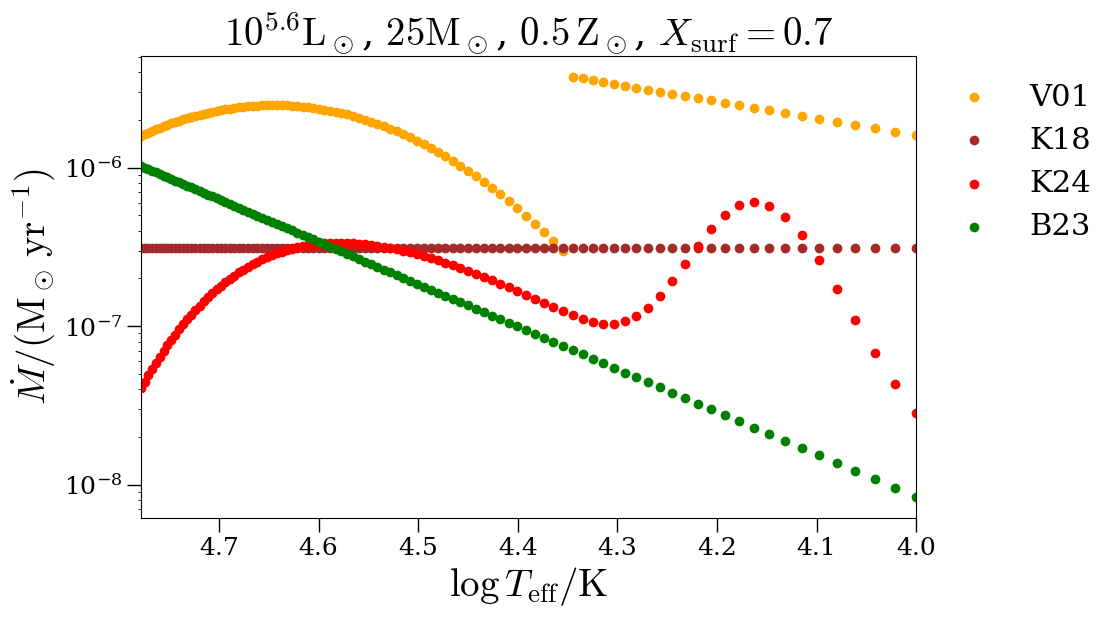

In [12]:
plot_x_len = 100

plot_teff = np.linspace(10000, 60000, plot_x_len)
plot_log_l = np.tile([5.6], plot_x_len)
plot_m = np.tile([25], plot_x_len)
plot_z = np.tile([Z_SUN/2], plot_x_len)
plot_x = np.tile([0.7], plot_x_len)

plot_v01 = np.array([
    vink2001_w(10.**log_l, m, teff, z) for log_l, m, teff, z in zip(plot_log_l, plot_m, plot_teff, plot_z)
])
plot_k18 = np.array([
    krticka2018_w(10.**log_l, z) for log_l, z in zip(plot_log_l, plot_z)
])
plot_k24 = np.array([
    krticka2024_w(10.**log_l, teff, z) for log_l, teff, z in zip(plot_log_l, plot_teff, plot_z)
])
plot_b23 = np.array([
    bjorklund2023_w(10.**log_l, m, teff, z, x) for log_l, m, teff, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])

fig, ax = plt.subplots(figsize=(10, 6))

x = np.log10(plot_teff)
invert_xaxis = True

ax.scatter(x, plot_v01, color=v01_c, label='V01')
ax.scatter(x, plot_k18, color=k18_c, label='K18')
ax.scatter(x, plot_k24, color=k24_c, label='K24')
ax.scatter(x, plot_b23, color=b23_c, label='B23')

ax.set_xlim(min(x), max(x))
if invert_xaxis:
    ax.invert_xaxis()
ax.set_yscale('log')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('$\log T_\mathrm{eff}/\mathrm{K}$')
ax.set_ylabel('$\dot{M}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
ax.set_title(', '.join((
    f'$10^{{{np.unique(plot_log_l)[0]}}}\mathrm{{L}}_\odot$',
    f'${np.unique(plot_m)[0]}\mathrm{{M}}_\odot$',
    f'${np.unique(plot_z)[0]/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$',
    f'$X_\mathrm{{surf}}={np.unique(plot_x)[0]:.1f}$'
)))

Text(0.5, 1.0, '$10^{5.6}\\mathrm{L}_\\odot$, $60\\mathrm{M}_\\odot$, $0.1\\,\\mathrm{Z}_\\odot$, $X_\\mathrm{surf}=1.0$')

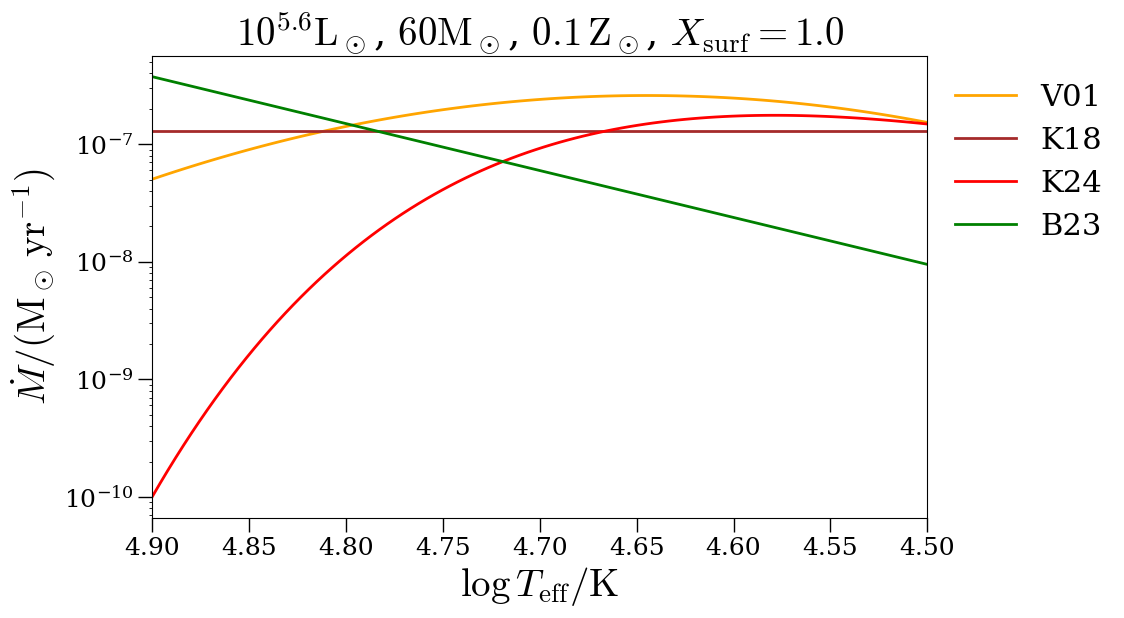

In [13]:
plot_x_len = 100

plot_teff = np.logspace(4.5, 4.9, plot_x_len)
plot_log_l = np.tile([5.6], plot_x_len)
plot_m = np.tile([60], plot_x_len)
plot_z = np.tile([Z_SUN/10], plot_x_len)
plot_x = np.tile([1], plot_x_len)

plot_v01 = np.array([
    vink2001_w(10.**log_l, m, teff, z) for log_l, m, teff, z in zip(plot_log_l, plot_m, plot_teff, plot_z)
])
plot_k18 = np.array([
    krticka2018_w(10.**log_l, z) for log_l, z in zip(plot_log_l, plot_z)
])
plot_k24 = np.array([
    krticka2024_w(10.**log_l, teff, z) for log_l, teff, z in zip(plot_log_l, plot_teff, plot_z)
])
plot_b23 = np.array([
    bjorklund2023_w(10.**log_l, m, teff, z, x) for log_l, m, teff, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])

fig, ax = plt.subplots(figsize=(10, 6))

x = np.log10(plot_teff)
invert_xaxis = True

ax.plot(x, plot_v01, color=v01_c, label='V01')
ax.plot(x, plot_k18, color=k18_c, label='K18')
ax.plot(x, plot_k24, color=k24_c, label='K24')
ax.plot(x, plot_b23, color=b23_c, label='B23')

ax.set_xlim(min(x), max(x))
if invert_xaxis:
    ax.invert_xaxis()
ax.set_yscale('log')
#ax.set_ylim(10.**-12, 10**-3)

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('$\log T_\mathrm{eff}/\mathrm{K}$')
ax.set_ylabel('$\dot{M}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
ax.set_title(', '.join((
    f'$10^{{{np.unique(plot_log_l)[0]}}}\mathrm{{L}}_\odot$',
    f'${np.unique(plot_m)[0]}\mathrm{{M}}_\odot$',
    f'${np.unique(plot_z)[0]/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$',
    f'$X_\mathrm{{surf}}={np.unique(plot_x)[0]:.1f}$'
)))

Text(0.5, 1.0, '$10^{4.75}\\mathrm{K}$, $60\\mathrm{M}_\\odot$, $0.1\\,\\mathrm{Z}_\\odot$, $X_\\mathrm{surf}=0.7$')

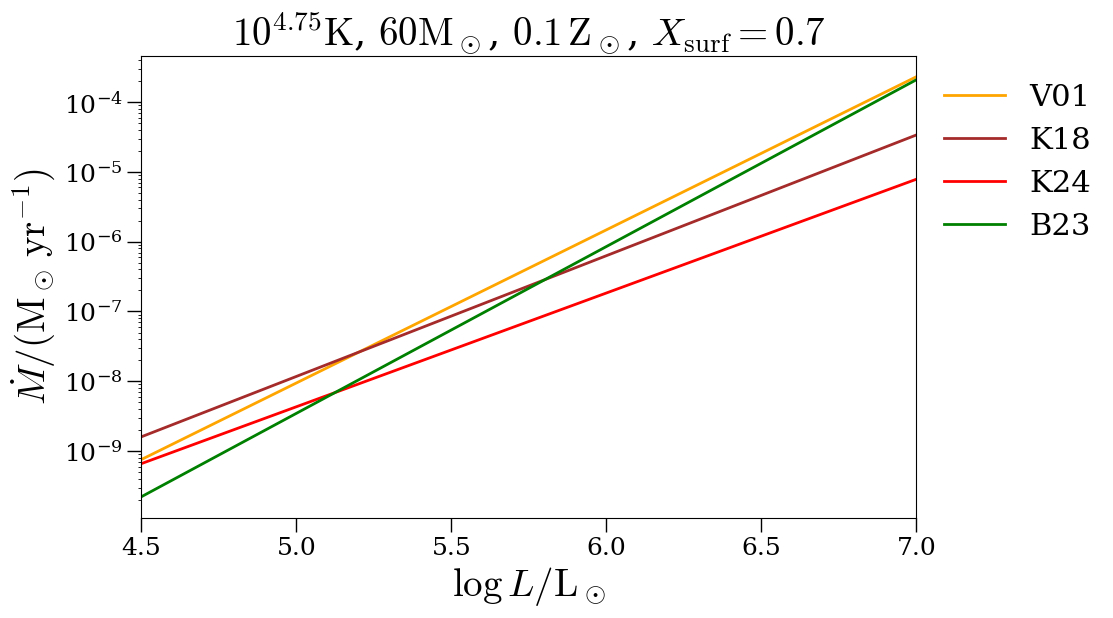

In [14]:
plot_x_len = 100

plot_log_l = np.linspace(4.5, 7, plot_x_len)
plot_teff = np.tile([10.**4.75], plot_x_len)
plot_m = np.tile([60], plot_x_len)
plot_z = np.tile([Z_SUN/10], plot_x_len)
plot_x = np.tile([0.7], plot_x_len)

plot_v01 = np.array([
    vink2001_w(10.**log_l, m, teff, z) for log_l, m, teff, z in zip(plot_log_l, plot_m, plot_teff, plot_z)
])
plot_k18 = np.array([
    krticka2018_w(10.**log_l, z) for log_l, z in zip(plot_log_l, plot_z)
])
plot_k24 = np.array([
    krticka2024_w(10.**log_l, teff, z) for log_l, teff, z in zip(plot_log_l, plot_teff, plot_z)
])
plot_b23 = np.array([
    bjorklund2023_w(10.**log_l, m, teff, z, x) for log_l, m, teff, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])

fig, ax = plt.subplots(figsize=(10, 6))

x = plot_log_l
invert_xaxis = False

ax.plot(x, plot_v01, color=v01_c, label='V01')
ax.plot(x, plot_k18, color=k18_c, label='K18')
ax.plot(x, plot_k24, color=k24_c, label='K24')
ax.plot(x, plot_b23, color=b23_c, label='B23')

ax.set_xlim(min(x), max(x))
if invert_xaxis:
    ax.invert_xaxis()
ax.set_yscale('log')
#ax.set_ylim(10.**-12, 10**-3)

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$\dot{M}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
ax.set_title(', '.join((
    f'$10^{{{np.log10(np.unique(plot_teff)[0]):.2f}}}\mathrm{{K}}$',
    f'${np.unique(plot_m)[0]}\mathrm{{M}}_\odot$',
    f'${np.unique(plot_z)[0]/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$',
    f'$X_\mathrm{{surf}}={np.unique(plot_x)[0]:.1f}$'
)))

Text(0.5, 1.0, '$10^{4.75}\\mathrm{K}$, $60\\mathrm{M}_\\odot$, $0.1\\,\\mathrm{Z}_\\odot$, $X_\\mathrm{surf}=0.3$')

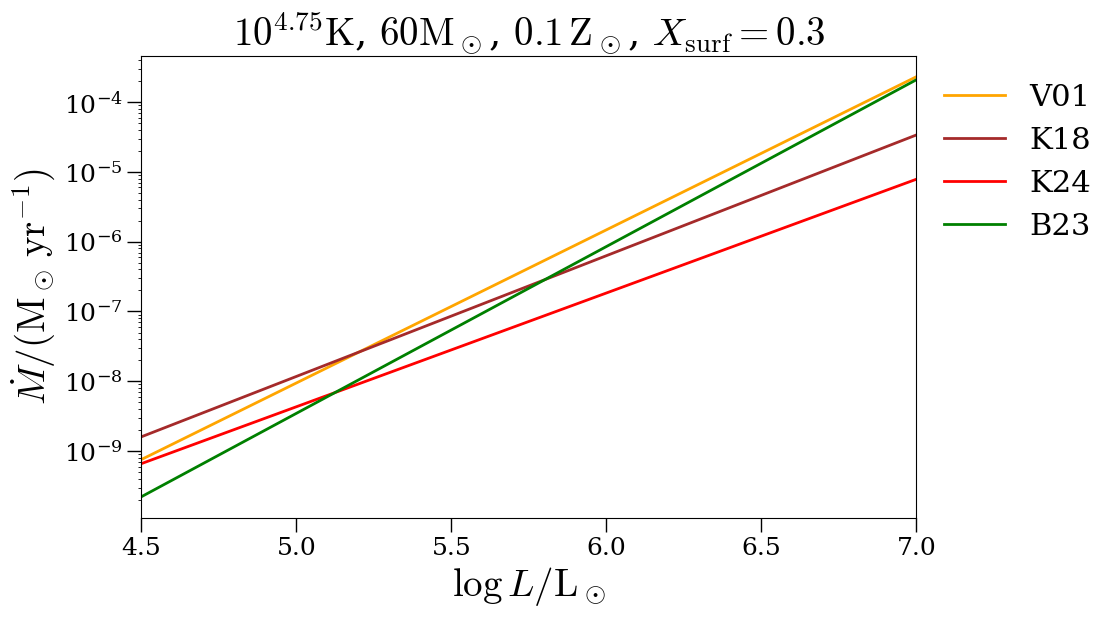

In [15]:
plot_x_len = 100

plot_log_l = np.linspace(4.5, 7, plot_x_len)
plot_teff = np.tile([10.**4.75], plot_x_len)
plot_m = np.tile([60], plot_x_len)
plot_z = np.tile([Z_SUN/10], plot_x_len)
plot_x = np.tile([0.3], plot_x_len)

plot_v01 = np.array([
    vink2001_w(10.**log_l, m, teff, z) for log_l, m, teff, z in zip(plot_log_l, plot_m, plot_teff, plot_z)
])
plot_k18 = np.array([
    krticka2018_w(10.**log_l, z) for log_l, z in zip(plot_log_l, plot_z)
])
plot_k24 = np.array([
    krticka2024_w(10.**log_l, teff, z) for log_l, teff, z in zip(plot_log_l, plot_teff, plot_z)
])
plot_b23 = np.array([
    bjorklund2023_w(10.**log_l, m, teff, z, x) for log_l, m, teff, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])

fig, ax = plt.subplots(figsize=(10, 6))

x = plot_log_l
invert_xaxis = False

ax.plot(x, plot_v01, color=v01_c, label='V01')
ax.plot(x, plot_k18, color=k18_c, label='K18')
ax.plot(x, plot_k24, color=k24_c, label='K24')
ax.plot(x, plot_b23, color=b23_c, label='B23')

ax.set_xlim(min(x), max(x))
if invert_xaxis:
    ax.invert_xaxis()
ax.set_yscale('log')
#ax.set_ylim(10.**-12, 10**-3)

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$\dot{M}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
ax.set_title(', '.join((
    f'$10^{{{np.log10(np.unique(plot_teff)[0]):.2f}}}\mathrm{{K}}$',
    f'${np.unique(plot_m)[0]}\mathrm{{M}}_\odot$',
    f'${np.unique(plot_z)[0]/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$',
    f'$X_\mathrm{{surf}}={np.unique(plot_x)[0]:.1f}$'
)))

We might be tempted to use K18 because it is well behaved throughout the luminosity range; but from Backs et al. (2024), B23 fits O stars below $10^6$ better.

### Thick winds

We consider two different models for **thick main sequence winds**, or **very massive star winds** (VMS winds): Vink et al. (2011) (**V11**) and Bestenlehner et al. (2020) (**B20**).

#### Vink et al. (2011) (V11)

In [16]:
v11_c = 'chartreuse'

The V11 models effectively extend V01 beyond $\Gamma_\mathrm{e}=0.4$, considering combinations of masses within $40-300\,\mathrm{M}_\odot$ and luminosities within $6.0\leq\log L/\mathrm{L}_\odot \leq 7.03$ that yield the desired $\Gamma_\mathrm{e}$, and providing fits for $\Gamma_\mathrm{e}<0.95$ (above this, "the results behave rather oddly"). Two fits are provided, above and below $\Gamma_\mathrm{e}=0.7$, as it is around this point that the winds are found to become optically thick, resulting in mass loss rates up to a factor of $5$ stronger than implied by V01. They find that, in the low-$\Gamma_\mathrm{e}$ side, a single ionization state of Fe dominates the wind driving domain, while in the high-$\Gamma_\mathrm{e}$ side, two or more do.

Separate fits are provided for the shape of the mass loss rate on each side of $\Gamma_\mathrm{e}=0.7$. As the difference between the V11 and V01 rates on the low-$\Gamma_\mathrm{e}$ side are small ($\lesssim10\%$), we implement only the high-$\Gamma_\mathrm{e}$ side,

$$
\frac{\dot{M}_\mathrm{V11}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} \propto M^{0.78}\Gamma_\mathrm{e}^{4.77}, \qquad \Gamma_\mathrm{switch}<\Gamma_\mathrm{e}<0.95,
$$

where $\Gamma_\mathrm{switch}=0.7$ in V11, but see the next section. V11 do not provide the normalization because their chosen self-consistent approach results in terminal velocities that are a factor of 2-4 higher than empirical velocities, which would have yielded higher mass loss rates (*comment: how does this play with the current idea that the V01 mass loss rates were overpredicted?*); as well as because $\Gamma_\mathrm{switch}$ is model-dependent. We thus keep $\Gamma_\mathrm{switch}$ a free parameterfor now, and set the normalization by continuity with the chosen MS prescription (in V11, there is no jump at $\Gamma_\mathrm{e}=0.7$). We extrapolate the model above $\Gamma_\mathrm{e}=0.95$; there is also the option within MESA to define a **linear super-Eddington boost**, and we might take this as physical motivation for turning the boost on at $\Gamma_\mathrm{e}=0.95$. 

Let $\dot{M}_\mathrm{MS}$ be our chosen MS wind prescription. Then, in summary,

$$\dot{M}_\mathrm{V11}(\Gamma_\mathrm{e})=\dot{M}_\mathrm{MS}(\Gamma_\mathrm{switch})\left(\frac{M}{M_\mathrm{switch}}\right)^{0.78} \left(\frac{\Gamma_\mathrm{e}}{\Gamma_\mathrm{switch}}\right)^{4.77},\qquad\Gamma_\mathrm{e}>\Gamma_\mathrm{switch}.$$

In [17]:
def vink2011_w(l, m, t, z, x, m_switch=None, g_switch=0.7):
    if m_switch is None:
        m_switch = m
    v01_w = vink2001_w(l, m, t, z)
    g_e = edd_gamma(l, m, x)
    
    if g_e <= g_switch:
        w = v01_w
    else:
        w = v01_w * (m/m_switch)**0.78 * (g_e/g_switch)**4.77
        
    return w

Text(0.5, 1.0, '$10^{4.75}\\mathrm{K}$, $60\\mathrm{M}_\\odot$, $0.1\\,\\mathrm{Z}_\\odot$, $X_\\mathrm{surf}=0.7$')

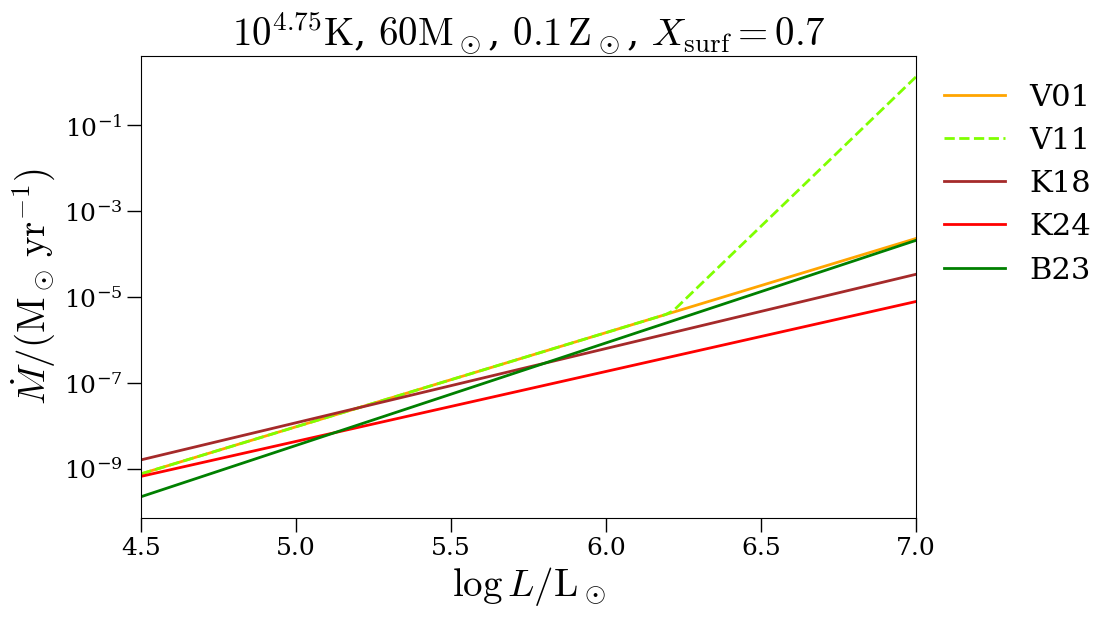

In [18]:
plot_x_len = 100

plot_log_l = np.linspace(4.5, 7, plot_x_len)
plot_teff = np.tile([10.**4.75], plot_x_len)
plot_m = np.tile([60], plot_x_len)
plot_z = np.tile([Z_SUN/10], plot_x_len)
plot_x = np.tile([0.7], plot_x_len)

plot_v01 = np.array([
    vink2001_w(10.**log_l, m, teff, z) for log_l, m, teff, z in zip(plot_log_l, plot_m, plot_teff, plot_z)
])
plot_v11 = np.array([
    vink2011_w(10.**log_l, m, t, z, x) for log_l, m, t, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])
plot_k18 = np.array([
    krticka2018_w(10.**log_l, z) for log_l, z in zip(plot_log_l, plot_z)
])
plot_k24 = np.array([
    krticka2024_w(10.**log_l, teff, z) for log_l, teff, z in zip(plot_log_l, plot_teff, plot_z)
])
plot_b23 = np.array([
    bjorklund2023_w(10.**log_l, m, teff, z, x) for log_l, m, teff, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])

fig, ax = plt.subplots(figsize=(10, 6))

x = plot_log_l
invert_xaxis = False

ax.plot(x, plot_v01, color=v01_c, label='V01')
ax.plot(x, plot_v11, color=v11_c, ls='--', label='V11')
ax.plot(x, plot_k18, color=k18_c, label='K18')
ax.plot(x, plot_k24, color=k24_c, label='K24')
ax.plot(x, plot_b23, color=b23_c, label='B23')

ax.set_xlim(min(x), max(x))
if invert_xaxis:
    ax.invert_xaxis()
ax.set_yscale('log')
#ax.set_ylim(10.**-12, 10**-3)

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$\dot{M}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
ax.set_title(', '.join((
    f'$10^{{{np.log10(np.unique(plot_teff)[0]):.2f}}}\mathrm{{K}}$',
    f'${np.unique(plot_m)[0]}\mathrm{{M}}_\odot$',
    f'${np.unique(plot_z)[0]/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$',
    f'$X_\mathrm{{surf}}={np.unique(plot_x)[0]:.1f}$'
)))

#### Bestenlehner et al. (2020) (B20)

B20 extend the CAK theory from thin to thick winds by replacing the mass in the standard CAK framework with a corrected mass that accounts for the flattening of the MLR for very massive stars,

$$
M=\mathcal{C}\frac{1}{\mu^2}\frac{\Gamma_\mathrm{e}^{1/2}}{(1-\Gamma_\mathrm{e})^2},
$$

with constant

$$
\mathcal{C}=-\frac{2}{G^{3/2}} \left(\frac{3c}{\pi\sigma}\right)^{1/2} R^2 \xi_1^2 \left(\frac{\mathrm{d}\theta}{\mathrm{d}\xi}\right)_{\xi=\xi_1}\approx-4.03648\left(\frac{3c}{\pi\sigma G^3}\right)^{1/2} R^2,
$$

and $\mu^{-1}\approx2X+0.7Y+0.5Z$. This effective MLR relies on three assumptions: 1) that the energy transport be fully radiative; 2) that $P=P_\mathrm{gas}+P_\mathrm{rad}$; and 3) that the $P_\mathrm{gas}/P=\beta$ is constant throughout the star.

resulting in 

$$
\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = \log\frac{\dot{M}_0}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} + (0.5+\alpha^{-1})\log\Gamma_\mathrm{e} - \left(\frac{1-\alpha}{\alpha}+2\right)\log(1-\Gamma_\mathrm{e}),
$$

where $M_0$ is a constant from CAK theory, and the $\Gamma_\mathrm{e}$ dependence dominates for thin O star winds, while $1-\Gamma_\mathrm{e}$ dominates for thick WNh star winds (as for higher luminosities the MLR approaches $L\propto M$). For stellar evolution models, however, B20 suggest normalizing their recipe by the mass loss rate at the switch between thin and thick winds, as we had defined for the V11 model. As before, we let the transition point remain a free parameter(s) for now. Finally, B20 find $\alpha=0.39$ for the force-multiplier parameter, based on a fit of the above relation to O and WNh stars in the star clusters R136 in the LMC.

While the B20 prescription is able to reproduce observations for $M=30-250\,\mathrm{M}_\odot$, remaining valid in the thin wind regime, for the sake of simplicity and of allowing the separate evaluation of MS and VMS wind models, we implement it with the same thin-thick switch as for the V11 model. In summary,

$$
\dot{M} = \dot{M}_\mathrm{switch} \left(\frac{\Gamma_\mathrm{e}}{\Gamma_\mathrm{switch}}\right)^{3.06} \left(\frac{1-\Gamma_\mathrm{e}}{1-\Gamma_\mathrm{switch}}\right)^{-3.56},\qquad\Gamma_\mathrm{e}>0.7.
$$

It is worth noting that the absence of an explicit dependence on $M_\mathrm{switch}$ in the B20 prescription is due to the assumed MLR above. However, it's hard to argue that condition 1) is fulfilled. While B20 argue that "O stars have a convective core and probably a convective outer zone as well, but they have large radiative envelopes", the core holds a large fraction of the star's mass, which only grows with the total mass. As stars lose their envelope through wind, it also becomes increasingly hard to argue that condition 1) is fulfilled to a reasonable approximation (though VMS also mix very efficiently and might spend relatively little time in the MS wind regime before transitioning to WR winds). We should prefer then to write the V11 prescription as is, instead of assuming the same MLR as in B20. We may also consider this point to make the V11 prescription preferrable over B20 for our 

### Thick wind scheme

By now it has become clear that the switch point between thin and thick winds --- marked by $\Gamma_\mathrm{switch}$ and $M_\mathrm{switch}$ is an essential quantity for VMS winds.

In [19]:
def sabhahit2023_switch_l(z):
    return 10.**2.36 * z**-1.91

def sabhahit2023_switch_m(z):
    return 0.0615 * z**-1.574 + 18.1

In [20]:
def vink2011_w(l, m, z):
    logmdot_switch = -1.86*np.log10(z) - 8.9
    l_switch = sabhahit2023_switch_l(z)
    m_switch = sabhahit2023_switch_m(z)
    w = 10.**logmdot_switch * (l/l_switch)**4.77 * (m/m_switch)**-3.99
    return w

In [21]:
def sabhahit2023_switch_g(z):
    l = sabhahit2023_switch_l(z)
    m = sabhahit2023_switch_m(z)
    return 2.5e-5 * l/m

One of the fundamental parameters for the thin-thick wind transition is the wind efficiency, defined in V11 as 

$$
\eta := \frac{\dot{M} v_\infty}{L/c}
$$

for a given mass loss rate choice $\dot{M}$, effectively the ratio of the wind to the radiative momentum flux. Surpassing the single electron scattering limit of $\eta=1$ is associated to the transition from thin to thick winds; observations and theory, however, support transitions at lower wind efficiencies. Vink & Gräfener (2012) found, for Galactic models, the transition to happen for an $\eta\approx0.6$. Sabhahit et al. (2023) sought to determine how this quantity varies with stellar parameters such as luminosity and temperature.

For a stationary wind ($\mathrm{d}v/\mathrm{d}t=0$), treating the sub-sonic region as being in hydrostatic equilibrium, and considering that the gas pressure force is negligible in the supersonic region, the hydrodynamic equation of motion can be written as 

$$
\dot{M}v_\infty = 4\pi GM \int_{r_\mathrm{s}}^\infty (\Gamma(r) - 1)\rho\,\mathrm{d}r,
$$

where the *total* Eddington factor, $\Gamma$, is 

$$
\Gamma(r) = \frac{g_\mathrm{rad}(r)}{g(r)} = \frac{1}{cg(r)} \int_0^\infty \varkappa_\nu F_\nu \,\mathrm{d}\nu = \frac{\varkappa_F(r)L}{4\pi GcM},
$$

with $\varkappa_F$ ($\mathrm{cm}^2\,\mathrm{g}^{-1}$) the flux-weighted mean opacity calculated in the comoving frame. Taking the flux-weighted mean optical depth at the sonic point,

$$
\tau_{F,\mathrm{s}} = \int^\infty_{r_\mathrm{s}}\varkappa_F\rho\,\mathrm{d}r,
$$

the equation of motion can be further simplified to

$$
\dot{M}v_\infty = \frac{L}{c}\left<\frac{\Gamma-1}{\Gamma}\right>_{r>r_\mathrm{s}}\tau_{F,\mathrm{s}}.
$$

If we can assume that $\Gamma\gg1$ in the supersonic region, then, from the definition of $\eta$, it is true that the transition to thick winds happens at $\eta=\tau_{F,\mathrm{s}}=1$. This is, however, not generally true, and thus a finite correction $f=\left<(\Gamma-1)/\Gamma\right>_{r>r_\mathrm{s}}$ must be adopted, so that the transition/switch is defined to happen at 

$$
\eta = f\tau_{F,\mathrm{s}}=f\qquad\mathrm{or}\qquad\dot{M}_\mathrm{switch}=f\frac{L_\mathrm{switch}/c}{v_{\infty,\mathrm{switch}}}.
$$

The correction factor $f$ is the quantity which Vink & Gräfener (2012) in fact determined as $\approx0.6$, and which Sabhahit et al. (2023) generalize.

From their atmosphere models, Sabhahit et al. (2023) found that $\eta$ and $\tau_{F,\mathrm{s}}$ could be connected as 

$$
\frac{\eta}{\tau_{F,\mathrm{s}}} \approx 0.75\left(1+\frac{v_\mathrm{esc}^2}{v_\infty^2}\right)^{-1}.
$$

The escape velocity is defined as

$$
v_\mathrm{esc}:=\sqrt{\frac{2GM}{R_\mathrm{crit}}},
$$

where the critical radius can be approximated by $R_{2/3}$, the radius where the Rosseland mean opacity equals $2/3$. The terminal velocity is found from

$$
v_\infty=2.6\sqrt{\frac{2GM_\mathrm{hom}(1-\Gamma_\mathrm{e}(L))}{R}}\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{0.2},
$$

Where $M_\mathrm{hom}$ is the corresponding mass of a homogeneous hydrogen-burning star from Gräfener et al. (2011). As in MESA the stellar radius is defined at $\tau=2/3$, we may write $R_\mathrm{crit}\approx R_{2/3}=R$, so that

$$
\frac{v_\mathrm{esc}}{v_\infty}=\frac{1}{2.6\sqrt{1-\Gamma_\mathrm{e}(L)}}\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.2}.
$$

Finally, the switch location is defined by $\tau_{F,\mathrm{s}}=1$, which we write as 

$$
\eta(L) = \frac{\eta}{\tau_{F,\mathrm{s}}}\left(\frac{v_\infty}{v_\mathrm{esc}}\right).
$$

Substituing in the equation above the previous expressions, we can reduce the definition of the switch to a single expression,

$$
\eta(L)=0.75\left[1+\frac{1}{6.76(1-\Gamma_\mathrm{e})}\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.4}\right]^{-1}
$$

Together with the definition of the wind efficiency, this equation sets the switch to VMS winds. I

S23 apply this framework to evaluate the switch point for the V01 winds, discarding its temperature terms and replacing the original $v_\infty/v_\mathrm{esc}\propto (Z/\mathrm{Z}_\odot)^{0.13}$ scaling with $v_\infty/v_\mathrm{esc}\propto (Z/\mathrm{Z}_\odot)^{0.20}$. For an exercise on the variation of the switch with stellar parameters, in their section 3 they assume the MLR from Gräfener et al. (2011) for H-burning homogeneous stars (i.e., ZAMS stars); define the radius through the Stefan-Boltzmann law; and set $T_\mathrm{eff}=45\,000\,\mathrm{K}$ and $X_\mathrm{surf}=0.7$. We reproduce that exercise below.

In [22]:
def s23_v_ter(l, m, r, z, x):
    l = fix_unit(l, u.Lsun)
    m = fix_unit(m, u.Msun)
    r = fix_unit(r, u.Rsun)
    g_e = edd_gamma(l.value, m.value, x)
    v_ter = (2.6
             * np.sqrt(2*ct.G*m * (1-g_e) / r)
             * (z/Z_SUN)**0.2)
    return v_ter.cgs.value

def s23_vter_div_vesc(l, m, z, x):
    g_e = edd_gamma(l, m, x)
    ratio = 2.6 * np.sqrt(1-g_e) * (z/Z_SUN)**0.2
    return ratio

def s23_wind_eff(l, m, r, mdot, z, x):
    l = fix_unit(l, u.Lsun)
    m = fix_unit(m, u.Msun)
    r = fix_unit(r, u.Rsun)
    mdot = fix_unit(mdot, u.Msun/u.yr)
    v_ter = s23_v_ter(l, m, r, z ,x) * u.cm/u.s
    wind_eff = v_ter*mdot / (l/ct.c)
    return wind_eff.to(u.dimensionless_unscaled).value

def s23_eta_switch(l, m, z, x):
    g_e = edd_gamma(l, m, x)
    eta_switch = 0.75 / (
        1 + 1/(6.76 * (1-g_e)) * (z/Z_SUN)**-0.4
    )
    return eta_switch

def s23_vink2001_w(l, m, z, x):
    #vinf_div_vesc = 2.6*(z/Z_SUN)**0.13 # original V01 scaling
    vinf_div_vesc = 2.6*(z/Z_SUN)**0.20 # updated scaling
    #vinf_div_vesc = s23_vter_div_vesc(l, m, z, x) # why do they not use their own expression for the ratio?
    log_mdot = (-6.697
                +2.194*np.log10(l/1e5)
                -1.313*np.log10(m/30)
                -1.226*np.log10(vinf_div_vesc/2)
                +0.85*np.log10(z/Z_SUN)) # no Teff terms
    mdot = 10.**log_mdot

    return mdot

In [23]:
def grafener_l_to_m_h_burning(l, x):
    """Equations 11, 12 from Gräfener et al. (2011).
    
    From relations 11, 12 and 13 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    
    FF11 = [4.026, 4.277, -1.0, 25.48, 36.93, -2.792, -3.226, -5.317, 1.648]
    FF12 = [2.582, 0.829, -1.0, 9.375, 0.333, 0.543, -1.376, -0.049, 0.036] 
    FF13 = [10.05, 8.204, -1.0, 151.7, 254.5, -11.46 ,-13.16, -31.68, 2.408]

    if l < 10.**6.5:
        FF = FF11
    else:
        FF = FF13
    f = FF[3] + FF[4]*x + FF[5]*x*x + (FF[6] + FF[7]*x) * np.log10(l)
    logm = (FF[0] + FF[1]*x + FF[2]*np.sqrt(f)) / (1 + FF[8]*x)
    m  = 10.**logm
  
    return m

def grafener_m_to_l_h_burning(m, x):
    """Equation 9 from Gräfener et al. (2011).
    
    From relations 1, 1 and 1 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    FF1 = [2.875, -3.966, 2.496, 2.652, -0.310, -0.511]
    FF2 = [1.967, -2.943, 3.755, 1.206, -0.727, -0.026]
    FF3 = [3.862, -2.486, 1.527, 1.247, -0.076, -0.183]
    
    FF = FF1
    log_l = (FF[0] + FF[1]*x
             + (FF[2] + FF[3]*x) * np.log10(m)
             + (FF[4] + FF[5]*x) * np.log10(m)**2)
    if log_l > 6.5:
        FF = FF3
        log_l = (FF[0] + FF[1]*x
             + (FF[2] + FF[3]*x) * np.log10(m)
             + (FF[4] + FF[5]*x) * np.log10(m)**2)
    return 10.**log_l

def grafener_l_to_m_he_burning(l):
    """Equation 18 from Gräfener et al. (2011).
    
    From relations 17, 16 and 18 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    
    FF = [8.177, -1.0, 105.5, -10.10] # 18
    #FF = [3.997, -1.0, 25.83, -3.268] # 16
    #FF = [3.059, -1.0, 14.76, -2.049] # 17
    logm = FF[0] + FF[1] * np.sqrt(FF[2] + FF[3] * np.log10(l))
    return 10.**logm

def grafener_m_to_l_he_burning(m):
    """Equation 10 from Gräfener et al. (2011).
    
    From relations 6, 7, and 8 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    #FF = [3.017, 2.446, -0.306] # 6
    #FF = [3.017, 2.446, -0.306] # 7
    FF = [3.826, 1.619, -0.099] # 8
    log_l = FF[0] + FF[1]*np.log10(m) + FF[2]*np.log10(m)**2
    return 10.**log_l

In [24]:
def sb_radius(l, teff):
    l = fix_unit(l, u.Lsun)
    teff = fix_unit(teff, u.K)
    r = np.sqrt(l/(4*np.pi*ct.sigma_sb*teff**4)).to(u.Rsun)
    return r.value

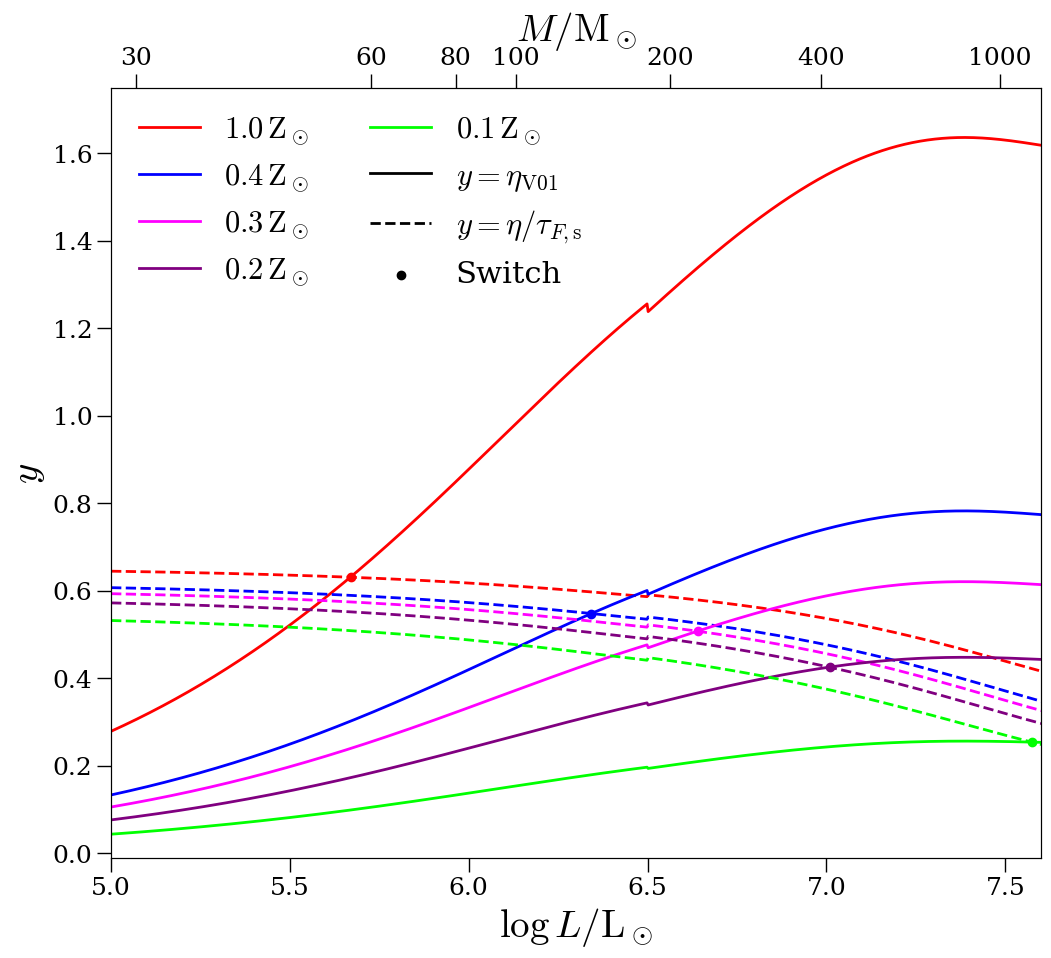

In [25]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = [zbase, zbase*0.4, zbase*0.3, zbase*0.2, zbase*0.1]
z_cs = ['red', 'blue', 'magenta', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(12, 10))
x = np.log10(switch_plot_l)
for z,c  in zip(test_zs, z_cs):
    switch_plot_z = np.tile([z], switch_plot_len)

    switch_plot_mdot = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_eta = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])

    ax.plot(x, switch_plot_eta, c=c, label=f'${z/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$')
    ax.plot(x, switch_plot_switch, '--', c=c)
    
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c)


ax.set_xlim(5, 7.6)
ax.set_ylim(-0.01, 1.75)
ax.set_yticks(np.arange(0, 1.8, 0.2))

ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$y$')

m_ax = ax.twiny()
m_ax.set_xlim(ax.get_xlim())
mticks = [30, 60, 80, 100, 200, 400, 1000]
lticks = [grafener_m_to_l_h_burning(m, switch_plot_x[0]) for m in mticks]
m_ax.set_xticks(np.log10(lticks))
m_ax.set_xticklabels([f'{m:.0f}' for m in mticks])
m_ax.set_xlabel('$M/\\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', label='$y=\\eta_\\mathrm{V01}$'))
handles.append(Line2D([], [], color='k', ls='--', label='$y=\\eta/\\tau_{F,\\mathrm{s}}$'))
handles.append(ax.scatter([], [], color='k', label='Switch'))
ax.legend(handles=handles, frameon=False, ncol=2)

The figure above is a reproduction of Figure 2 from Sabhahit et al. (2023) with an added $0.3\,\mathrm{Z}_\odot$ case. As $\eta_\mathrm{V01}=\eta/\tau_{f,\mathrm{s}}$ only if $\tau_{f,\mathrm{s}}=1$, the point where they cross marks the onset of thick winds. From previous runs with V01 MS winds, we know that a maximum of $\approx10^{6.7}\,\mathrm{L}_\odot$ is reached by $M_\mathrm{ZAMS}=300\,\mathrm{M}_\odot$ stars. As the plot above assumes a ZAMS MLR, we conclude that none of our stars will have thick winds *at ZAMS* for metallicities $<0.3\,\mathrm{Z}_\odot$; as the V01 model has the strongest MS winds in our set of models, this is true also for the K24 and B23 models ($\eta\propto\dot{M}$). With this framework in hand, we can now extended the exercise from Sabhahit et al. (2023) to the other wind models and check for the location of this metallicity threshold.

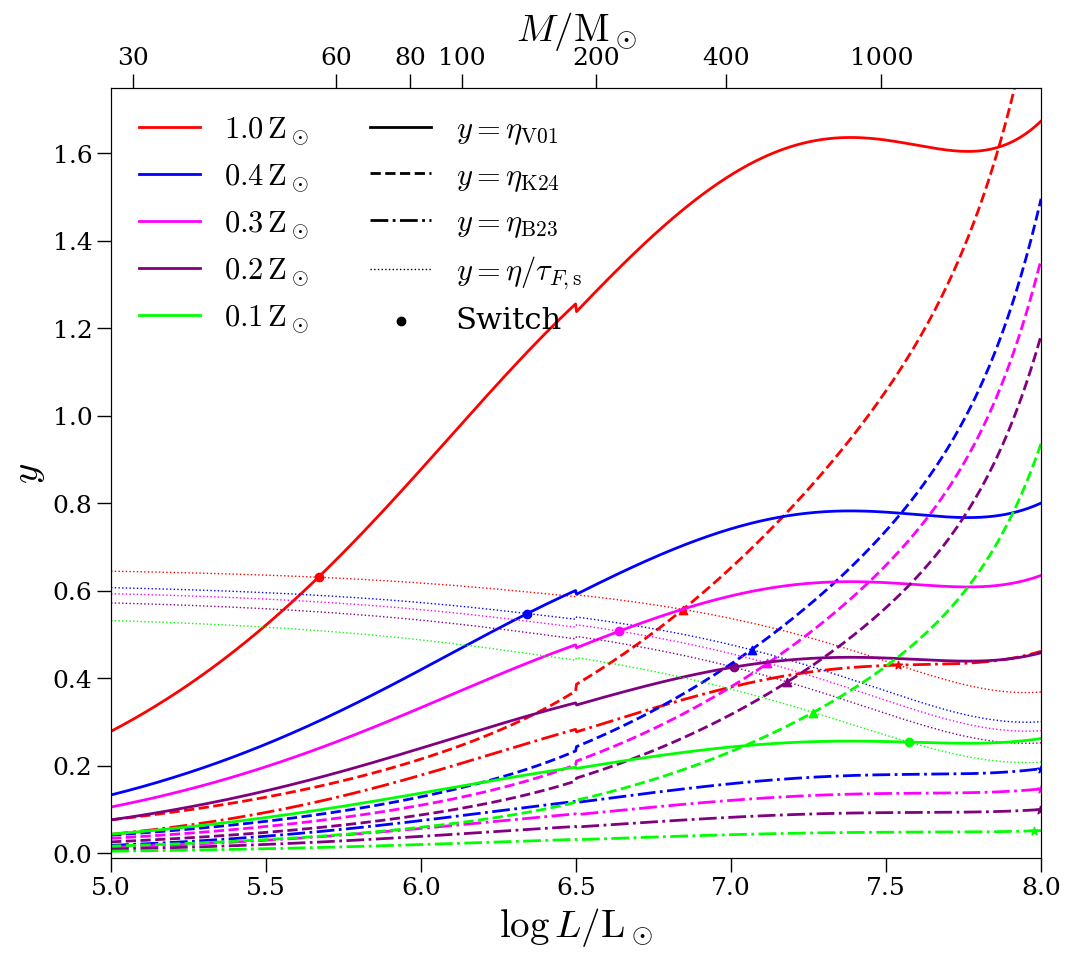

In [26]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = [zbase, zbase*0.4, zbase*0.3, zbase*0.2, zbase*0.1]
z_cs = ['red', 'blue', 'magenta', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(12, 10))
x = np.log10(switch_plot_l)
for z,c  in zip(test_zs, z_cs):
    switch_plot_z = np.tile([z], switch_plot_len)

    switch_plot_mdot_s23v01 = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot_v01 = np.array([
        vink2001_w(l, m, t, z) for l, m, t, z in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z)
    ])
    switch_plot_mdot_k24 = np.array([
        krticka2024_w(l, t, z) for l, t, z in zip(switch_plot_l, switch_plot_t, switch_plot_z)
    ])
    switch_plot_mdot_b23 = np.array([
        bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z, switch_plot_x)
    ])
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    
    switch_plot_mdot = switch_plot_mdot_s23v01
    switch_plot_eta_s23v01 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_v01
    switch_plot_eta_v01 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_k24
    switch_plot_eta_k24 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_b23
    switch_plot_eta_b23 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])

    ax.plot(x, switch_plot_eta_s23v01, c=c, ls='-', lw=2, label=f'${z/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$')
    #ax.plot(x, switch_plot_eta_v01, c=c, ls='-', lw=1)
    ax.plot(x, switch_plot_eta_k24, c=c, ls='--', lw=2)
    ax.plot(x, switch_plot_eta_b23, c=c, ls='-.', lw=2)
    ax.plot(x, switch_plot_switch, ':', c=c, lw=1)
    
    switch_plot_eta = switch_plot_eta_s23v01
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c, marker='o')
    
    #switch_plot_eta = switch_plot_eta_v01
    #switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    #switch_y = switch_plot_eta[switch_i]
    #ax.scatter(x[switch_i], switch_y, color=c, marker='s')
    
    switch_plot_eta = switch_plot_eta_k24
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c, marker='^')
    
    switch_plot_eta = switch_plot_eta_b23
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c, marker='*')


ax.set_xlim(5, 8)
ax.set_ylim(-0.01, 1.75)
ax.set_yticks(np.arange(0, 1.8, 0.2))

ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$y$')

m_ax = ax.twiny()
m_ax.set_xlim(ax.get_xlim())
mticks = [30, 60, 80, 100, 200, 400, 1000]
lticks = [grafener_m_to_l_h_burning(m, switch_plot_x[0]) for m in mticks]
m_ax.set_xticks(np.log10(lticks))
m_ax.set_xticklabels([f'{m:.0f}' for m in mticks])
m_ax.set_xlabel('$M/\\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', lw=2, label='$y=\\eta_\\mathrm{V01}$'))
#handles.append(Line2D([], [], color='k', ls='-', lw=1, label='$y=\\eta_\\mathrm{V01}$'))
handles.append(Line2D([], [], color='k', ls='--', lw=2, label='$y=\\eta_\\mathrm{K24}$'))
handles.append(Line2D([], [], color='k', ls='-.', lw=2, label='$y=\\eta_\\mathrm{B23}$'))
handles.append(Line2D([], [], color='k', ls=':', lw=1, label='$y=\\eta/\\tau_{F,\\mathrm{s}}$'))
handles.append(ax.scatter([], [], color='k', label='Switch'))
ax.legend(handles=handles, frameon=False, ncol=2)

As expected, the more intrinsically weak the winds are, the higher the luminosity required for the onset of thick winds is. Generally, at ZAMS, V01 is stronger than K24, which is stronger than B23; this only breaks down for extremely high luminosities never reached by our models, but check below for an explanation for why K24>V01 in that range. We can also now see that winds weaker than V01 are not generally able to enter the thick regime at ZAMS: B23 is clearly far removed from the luminosity range required, even at Solar metallicity; and K24 still requires $L\gtrsim10^{6.75}\,\mathrm{L}_\odot$ at ZAMS to switch to thick winds. This transition might still happen, however, as the star continues increasing its Eddington factor during the MS. A transition from thin to thick winds *during* the MS was already a feature of the original tracks in Sabhahit et al. (2023), assuming V01; even their $500\,\mathrm{M}_\odot$ star has thin winds at ZAMS (their figure 5). 

As for the K24 becoming stronger than V01 at very high luminosities, we see this explicitly in the mass loss rates below.

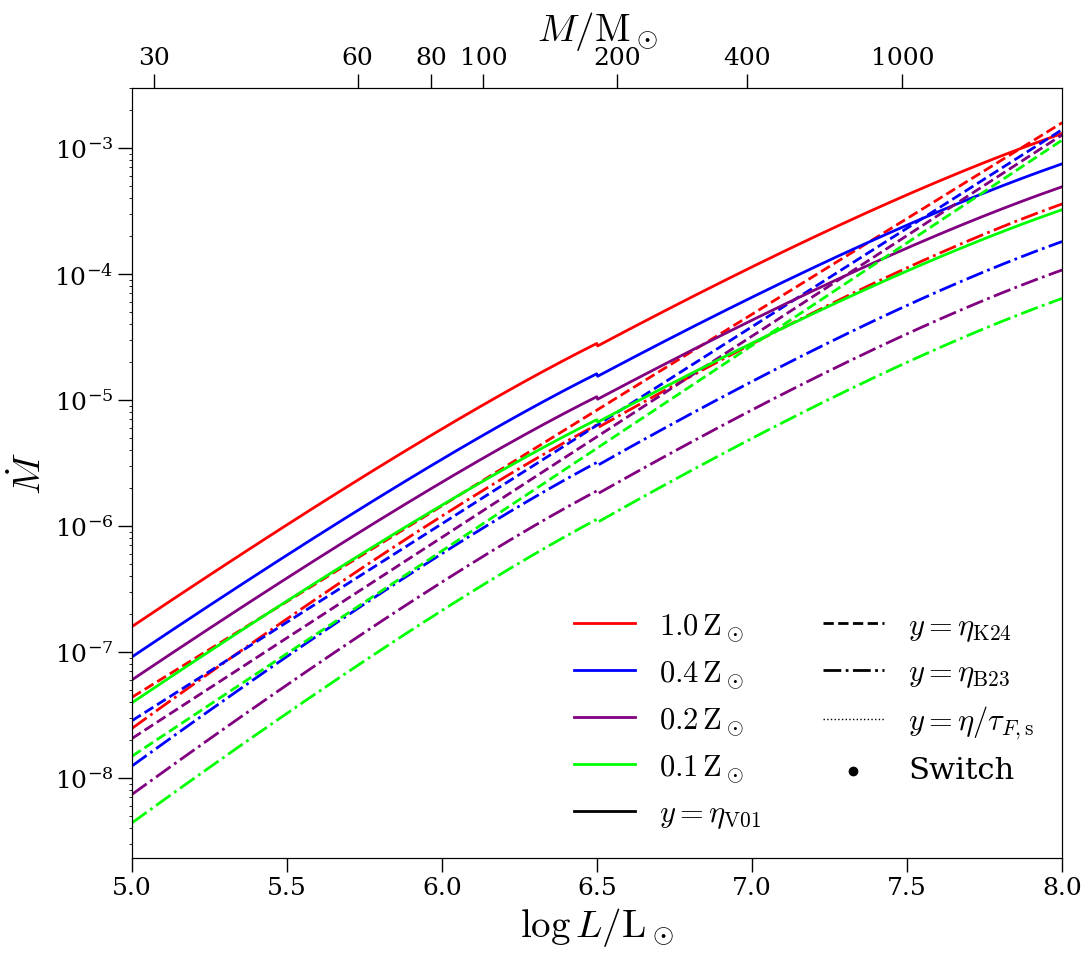

In [27]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = [zbase, zbase*0.4, zbase*0.2, zbase*0.1]
z_cs = ['red', 'blue', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(12, 10))
x = np.log10(switch_plot_l)
for z,c  in zip(test_zs, z_cs):
    switch_plot_z = np.tile([z], switch_plot_len)

    switch_plot_mdot_s23v01 = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot_v01 = np.array([
        vink2001_w(l, m, t, z) for l, m, t, z in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z)
    ])
    switch_plot_mdot_k24 = np.array([
        krticka2024_w(l, t, z) for l, t, z in zip(switch_plot_l, switch_plot_t, switch_plot_z)
    ])
    switch_plot_mdot_b23 = np.array([
        bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z, switch_plot_x)
    ])
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    
    switch_plot_mdot = switch_plot_mdot_s23v01
    switch_plot_eta_s23v01 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_v01
    switch_plot_eta_v01 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_k24
    switch_plot_eta_k24 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_b23
    switch_plot_eta_b23 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])

    ax.plot(x, switch_plot_mdot_s23v01, c=c, ls='-', lw=2, label=f'${z/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$')
    #ax.plot(x, switch_plot_eta_v01, c=c, ls='-', lw=1)
    ax.plot(x, switch_plot_mdot_k24, c=c, ls='--', lw=2)
    ax.plot(x, switch_plot_mdot_b23, c=c, ls='-.', lw=2)


ax.set_xlim(5, 8)
#ax.set_ylim(-0.01, 1.75)
ax.set_yticks(np.arange(0, 1.8, 0.2))

ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$\dot{M}$')
ax.set_yscale('log')

m_ax = ax.twiny()
m_ax.set_xlim(ax.get_xlim())
mticks = [30, 60, 80, 100, 200, 400, 1000]
lticks = [grafener_m_to_l_h_burning(m, switch_plot_x[0]) for m in mticks]
m_ax.set_xticks(np.log10(lticks))
m_ax.set_xticklabels([f'{m:.0f}' for m in mticks])
m_ax.set_xlabel('$M/\\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', lw=2, label='$y=\\eta_\\mathrm{V01}$'))
#handles.append(Line2D([], [], color='k', ls='-', lw=1, label='$y=\\eta_\\mathrm{V01}$'))
handles.append(Line2D([], [], color='k', ls='--', lw=2, label='$y=\\eta_\\mathrm{K24}$'))
handles.append(Line2D([], [], color='k', ls='-.', lw=2, label='$y=\\eta_\\mathrm{B23}$'))
handles.append(Line2D([], [], color='k', ls=':', lw=1, label='$y=\\eta/\\tau_{F,\\mathrm{s}}$'))
handles.append(ax.scatter([], [], color='k', label='Switch'))
ax.legend(handles=handles, frameon=False, ncol=2)

Both V01 and B23 start to flatten out at high luminosities, while K24 does not. This is due to the fact that K24 is only directly dependent on the luminosity, temperature and metallicity, while V01 and B23 are also mass-dependent; the more massive the star, the weaker the winds. From the G11 MLR, mass starts to vary more rapidly with luminosity at high luminosities, and so $\dot{M}$ responds by flattening out. V01 also has a stronger dependence on metallicity ($\propto(Z/\mathrm{Z}_\odot)^{0.85}$) than K24 ($\propto(Z/\mathrm{Z}_\odot)^{0.358}$), such that the lower the metallicity, the lower the luminosity at which K24 overtakes V01 is.

When implementing their framework for the wind switch in MESA, Sabhahit et al. (2023), for each model in MESA, adopt $T_\mathrm{model}$ and $X_{\mathrm{surf},\mathrm{model}}$, and then follow the above procedure to find the $\Gamma_\mathrm{switch}$ for a ZAMS star with those parameter (i.e., they assume the same G11 MLR). They provide some resulting $L_\mathrm{switch}$ and $M_\mathrm{switch}$ in their table 2 for varying metallicity, over which Merritt et al. (in prep.) fit two power-laws. Together with the definition of $G_\mathrm{e}$, this provides a fit for $\Gamma_\mathrm{switch}$,

$$\Gamma_\mathrm{switch} = 2.50\times10^{-5}\left(\frac{L_\mathrm{switch}}{\mathrm{L}_\odot}\right)\left(\frac{M_\mathrm{switch}}{\mathrm{M}_\odot}\right)^{-1},$$

where

$$\frac{L_\mathrm{switch}}{\mathrm{L}_\odot}=10^{2.36}Z^{-1.91},$$

and

$$\frac{M_\mathrm{switch}}{\mathrm{M}_\odot}=0.0615Z^{-1.574} + 18.10.$$

We compare this fit to the original method below.

**Note:** in keeping with V11, S23 adopt $\mathrm{Z}_\odot=0.019$, so an extra scaling must be passed to the Merritt fit in order to keep the same behavior with $Z/\mathrm{Z}_\odot$ if a different $\mathrm{Z}_\odot$ is adopted.

Text(0.5, 0, '$Z/\\mathrm{Z}_\\odot$')

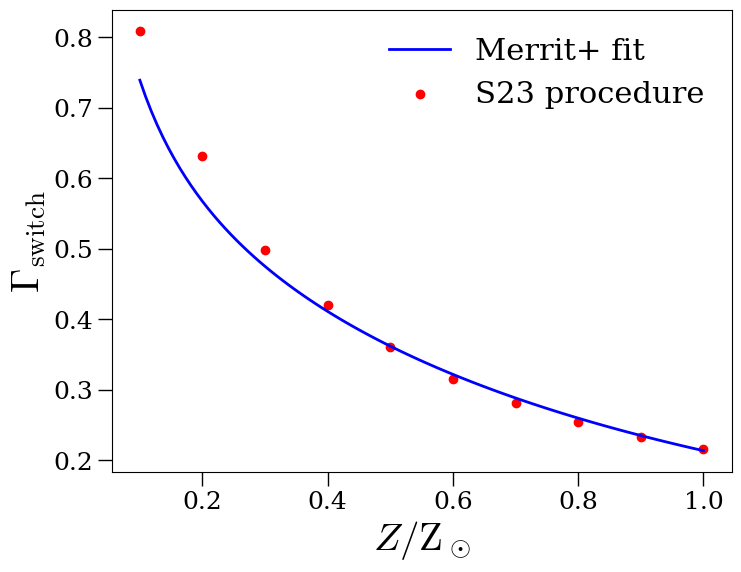

In [28]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = np.linspace(0.1, 1, 10) * zbase
z_cs = ['red', 'blue', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(8, 6))
x = np.log10(switch_plot_l)
for z in test_zs:
    switch_plot_z = np.tile([z], switch_plot_len)

    switch_plot_mdot = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_eta = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_l = switch_plot_l[switch_i]
    switch_m = switch_plot_m[switch_i]
    switch_x = switch_plot_x[switch_i]
    switch_ge = edd_gamma(switch_l, switch_m, switch_x)
    ax.scatter(z/Z_SUN, switch_ge, color='r')
    
# we have assumed Z_SUN=0.014, while S23 use Z_SUN=0.020, so for an accurate comparison we rescale the fit
ax.plot(np.linspace(0.1, 1, 100), sabhahit2023_switch_g(np.linspace(0.1, 1, 100)*0.02), 'b-', label='Merrit+ fit')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], color='r', label='S23 procedure'))
ax.legend(frameon=False)

ax.set_ylabel('$\Gamma_\mathrm{switch}$')
ax.set_xlabel('$Z/\mathrm{Z}_\odot$')

We notice an increasing mismatch for $Z<0.4\,\mathrm{Z}_\odot$, such that some borderline cases that should not have VMS winds will acquire them. But what does $\Gamma_\mathrm{switch}$ look like for other MS wind prescriptions? We check below.

In [29]:
def g_e_switch_data(
    switch_plot_l,
    switch_plot_m, 
    switch_plot_r, 
    switch_plot_z,
    switch_plot_x,
    switch_plot_mdot
):
    
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_eta = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_l = switch_plot_l[switch_i]
    switch_m = switch_plot_m[switch_i]
    switch_x = switch_plot_x[switch_i]
    switch_ge = edd_gamma(switch_l, switch_m, switch_x)
    
    return switch_ge

Text(0.5, 0, '$Z/\\mathrm{Z}_\\odot$')

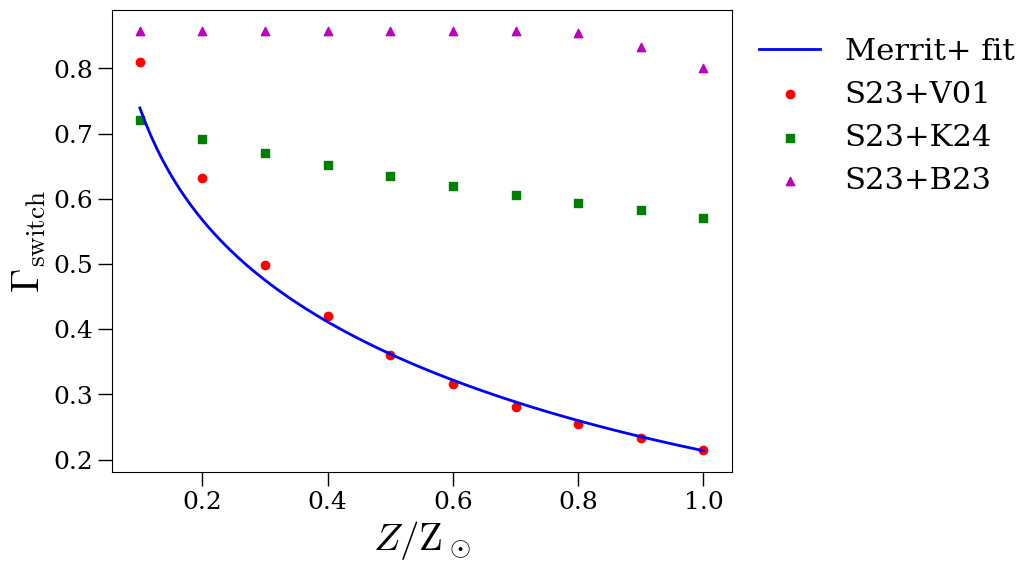

In [30]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = np.linspace(0.1, 1, 10) * zbase
z_cs = ['red', 'blue', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(8, 6))
x = np.log10(switch_plot_l)
for z in test_zs:
    switch_plot_z = np.tile([z], switch_plot_len)
    switch_plot_mdot = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    v01_switch_ge = g_e_switch_data(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_z, switch_plot_x, switch_plot_mdot)
    
    switch_plot_mdot = np.array([
        krticka2024_w(l, t, z) for l, t, z in zip(switch_plot_l, switch_plot_t, switch_plot_z)
    ])
    k24_switch_ge = g_e_switch_data(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_z, switch_plot_x, switch_plot_mdot)
    
    switch_plot_mdot = np.array([
        bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z, switch_plot_x)
    ])
    b23_switch_ge = g_e_switch_data(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_z, switch_plot_x, switch_plot_mdot)
        
    ax.scatter(z/Z_SUN, v01_switch_ge, color='r', marker='o')
    ax.scatter(z/Z_SUN, k24_switch_ge, color='g', marker='s')
    ax.scatter(z/Z_SUN, b23_switch_ge, color='m', marker='^')
    
# we have assumed Z_SUN=0.014, while S23 use Z_SUN=0.020, so for an accurate comparison we rescale the fit
ax.plot(np.linspace(0.1, 1, 100), sabhahit2023_switch_g(np.linspace(0.1, 1, 100)*0.02), 'b-', label='Merrit+ fit')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], color='r', marker='o', label='S23+V01'))
handles.append(ax.scatter([], [], color='g', marker='s', label='S23+K24'))
handles.append(ax.scatter([], [], color='m', marker='^', label='S23+B23'))
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

ax.set_ylabel('$\Gamma_\mathrm{switch}$')
ax.set_xlabel('$Z/\mathrm{Z}_\odot$')

The chief trends remain: stronger winds and higher metallicities favor a switch to thick winds. The combination of (a lack of) mass-dependence and metallicity scaling allows K24 to become more favorable to thick winds than V01 for $0.1\mathrm{Z}_\odot$, but still with a high $\Gamma_\mathrm{switch}\approx0.7$.

The catch here, of course, is that this computation relies on several assumptions, chief of all on the MLR for a ZAMS star. In addition, it also fixes the radius to the Stefan-Boltzmann, assumes a fixed temperature and a fixed surface hydrogen fraction. In their implementation of VMS winds in MESA, S23 instead adopt the temperature and surface hydrogen of the model at each step; but continue to assume the ZAMS MLR and define the radius through the Stefan-Boltzmann law. If we choose to follow the same implementation as in S23, then fitting for the points above, for each wind model, will allow a more accurate tracking of the transition.

What do we get if we instead use the mass, luminosity and radius from each model to check whether its $\Gamma_\mathrm{e}$ is above a $\Gamma_\mathrm{switch}$ defined in the same way? I.e., whether or not $\tau_{F,\mathrm{s}}$ from the current properties of the star? While we can only check the behavior of this method consistently by running new models with it implemented, we may try to get an idea by applying it to a model that has already been run using the Merritt+ fit.

model_ids = [4]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

switch_test_h = mr.MesaData(str(model_dicts[0]['300.0']['3.00']/'LOGS/history.data'))

switch_test_begin = np.where(switch_test_h.surf_avg_omega>0)[0][0]

switch_test_age = switch_test_h.star_age[switch_test_begin:]
switch_test_l = 10.**switch_test_h.log_L[switch_test_begin:]
switch_test_m = switch_test_h.star_mass[switch_test_begin:]
switch_test_r = switch_test_h.radius[switch_test_begin:]
switch_test_x = switch_test_h.surface_h1[switch_test_begin:]
switch_test_t = switch_test_h.Teff[switch_test_begin:]
switch_test_z = np.tile([Z_SUN/10], len(switch_test_l))
switch_test_mdot = switch_test_h.log_abs_mdot[switch_test_begin:]

switch_test_g_e = edd_gamma(switch_test_l, switch_test_m, switch_test_x)

switch_test_eta = np.array([
    s23_wind_eff(l, m, r, 10.**log_mdot, z, x) for l, m, r, log_mdot, z, x in zip(switch_test_l, switch_test_m, switch_test_r, switch_test_mdot, switch_test_z, switch_test_x)
])
switch_test_switch = np.array([
    s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_test_l, switch_test_m, switch_test_z, switch_test_x)
])
switch_test_fit_switch = np.array([
    sabhahit2023_switch_g(z) for z in switch_test_z
])

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(switch_test_age/1e6, switch_test_g_e, 'b-', label='$y=\\Gamma_\\mathrm{e}^\\mathrm{MESA}$')
ax.plot(switch_test_age/1e6, switch_test_fit_switch, 'b--', label='$y=\\Gamma_\\mathrm{e}^\\mathrm{Merritt}$')
ax.plot(switch_test_age/1e6, switch_test_eta, 'r-', label='$y=\\eta_\\mathrm{MESA}$')
ax.plot(switch_test_age/1e6, switch_test_switch, 'r--', label='$y=(\\eta/\\tau_{F,\\mathrm{s}})_\\mathrm{S23}$')

ax.set_ylim(0, 2)

ax.set_ylabel('$y$')
ax.set_xlabel('Age/Myr')
ax.legend(frameon=False)

As we had verified before, for the metallicity this model was run for ($0.1\,\mathrm{Z}_\odot$), even the V01 winds are not strong enough to become optically thick, and so there is no transition (the blue solid and dashed lines never cross). When tracking the mass loss rates in use by MESA, we still get no transition; the rapid increase in the wind efficiency parameter is due to the switch to WR winds instead. For consistency, we verify that the S23 framework does classify these winds as thick (the red solid and dashed lines cross).

It is hard to evaluate the effect of the different approaches to the VMS switch without implementing them in the models and at such low metallicities. A run with $\geq0.3\,\mathrm{Z}_\odot$ will likely be necessary here.

## Wolf-Rayet winds

In [31]:
s23_c = 'cyan'
v17_c = 'magenta'

We consider a fixed combination of models for Wolf-Rayet and low-mass He star winds: the prescription from Vink (2017) (**V17**) for low-luminosity stars; and the prescription from Sander & Vink (2020) (**S20**), with the Sander et al. (2023) temperature correction (**S23**).

#### Vink (2017) (V17)

V17 focuses on predicting the mass loss rates of He stars in the $2-20\,\mathrm{M}_\odot$ range, but extend their models from $0.6\,\mathrm{M}_\odot$ to $60\,\mathrm{M}_\odot$; luminosities follow from the G11 MLRs. Although the effective temperature *is* expected  to affect mass loss rates, they fix $T_\mathrm{eff}=50\,000\,\mathrm{K}$, characteristic of the stripped He star HD45166, and do not vary it as radii are uncertain due to "envelope inflation and the possibly associated clumped nature of stellar envelopes". They find the fit

$$
\log\frac{\dot{M}_\mathrm{V17}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = -13.3 + 1.36\log\frac{L}{\mathrm{L}_\odot} + 0.61\log\frac{Z}{\mathrm{Z}_\odot},
$$

in the range $0.01-1\,\mathrm{Z}_\odot$ and $2-60\,\mathrm{M}_\odot$, with error $\sigma=0.11$. V17 does not provide a $\Gamma_\mathrm{e}$ recipe as that would depend on the amount of ionized He versus H, while it had been previously shown (e.g., by V11) that the mass loss rate should hardly depend on the amount of He. It is, in any case, possible to rewrite the recipe in terms of $\Gamma_\mathrm{e}$ if needed, by substituting for equations (13) and (B.18) from G11 (or by using them to find a new fit over $\Gamma_\mathrm{e}$).

In [32]:
def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

#### Sander & Vink (2020); Sander et al. (2023)

S20 models the mass loss rates of He stars with masses $7.3-500\,\mathrm{M}_\odot$ and luminosities $10^{4.85}-10^{7.47}\,\mathrm{L}_\odot$, paired according to the MLRs from G11 for He-burning homogeneous stars. They also fix $T_\mathrm{eff}=141\,000\,\mathrm{K}$, and caution that this choice is not necessarily representative of the lower end of their mass and luminosity range, which probes the breakdown of WR-like mass loss and the transition to thin winds; results for stripped He stars below $10\,\mathrm{M}_\odot$ are to be treated carefully. 

From their results, they find the mass loss rates as a function of luminosity to be aproppriately described by


$$
\log\frac{\dot{M}_\mathrm{S20}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = \log\dot{M}_{10} + \alpha\log\frac{L}{L_0} + 0.75\log\frac{L}{10L_0},
$$

with

$$
\begin{align*}
&\alpha = 0.32\log\frac{Z}{\mathrm{Z}_\odot} + 1.40, \\
&\log\frac{L}{L_0} = -0.87\log\frac{Z}{\mathrm{Z}_\odot} + 5.06, \\
&\log\frac{\dot{M}_{10}}{\mathrm{M}\,\mathrm{yr}} = -0.75\log\frac{Z}{\mathrm{Z}_\odot} - 4.06,
\end{align*}
$$

where $L_0$ is the asymptotic limit for which there is theoretically zero mass-loss; $\alpha$ describes the curvature of the breakdown of the WR regime; and $\dot{M}_{10}:=\dot{M}_\mathrm{S20}(L=10L_0)$.

For a $\Gamma_\mathrm{e}$-dependent recipe, V20 consider using the same parametrization as in B20, but discard it as it cannot capture the breakdown of the WR regime. They do, however, maintain the need for a $1-\Gamma_\mathrm{e}$ to appropriately capture the behavior of thick winds. They find the mass loss rates to be best described by 

$$\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = 2.932\log[-\log(1-\Gamma_\mathrm{e})] - \log(2)\left(\frac{\Gamma_\mathrm{e,b}}{\Gamma_\mathrm{e}}\right)^c + d,$$

where $\Gamma_\mathrm{e,b}$ is the "breakdown [of WR winds] indicator", defined so that it equals the Eddington factor at which $\dot{M}$ deviates from the "pure WR regime" (where $\log\dot{M}\propto\log[-\log(1-\Gamma_\mathrm{e})]$) by a factor of 2, given as

$$\Gamma_\mathrm{e,b}=-0.324\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot} + 0.244;$$

$c$ captures the "acceleration" of the breakdown of WR-winds,

$$c=-0.44\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot} + 9.15;$$

and $d$ denotes $\log\dot{M}(\Gamma_\mathrm{e}\approx0.9)$,

$$d=0.23\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot}-2.61.$$

S23 later extended the study to encompass also the temperature dependence of WR winds launched by the hot iron bump, running a set of models with temperatures within $80-220\,\mathrm{kK}$, luminosities $5.35,5.475,5.7\,\mathrm{L}_\odot$ and masses $12.9,15,20\,\mathrm{M}_\odot$. They determine a temperature-based correction to the S20 prescription,

$$
\log\frac{\dot{M}_\mathrm{S23}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = \log\frac{\dot{M}_\mathrm{S20}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} - 6\log\frac{T_\mathrm{eff,crit}}{141\,\mathrm{kK}},
$$

and they also find that *no wind can be launched from the hot iron bump for $T_\mathrm{eff}\lesssim100\,\mathrm{kK}$.* Therefore, strictly speaking, there *should not be S20 winds* for those lower temperatures, and we would apply only the weaker V17 winds. 

The $L$- and $\Gamma_\mathrm{e}$-prescriptions behave very differently when applied naïvely to stellar evolution calculations, as only the latter allows the G11 MLR assumed in the former to be "bypassed", as $\Gamma_\mathrm{e}$ can be simply computed for any $M$, $L$ pair. It is, however, worth considering whether this is valid, as the atmosphere models on which the prescriptions were based *were* calculated for $M$, $L$ pairs following the G11 MLRs; should even the $\Gamma_\mathrm{e}$-prescription be valid for pairs that do not follow this MLR? On the other hand, we may also argue that using the $L$-prescription before or beyond the HeMS also induces errors, as there is an implicit assumption that the star's mass always follows the G11 MLR. 

To support this discussion, below we succintly compute and compare both prescriptions.

In [33]:
def sander2020_ge_w(g_e, z):
    g_eb = -0.324*np.log10(z/Z_SUN) + 0.244
    c = -0.44*np.log10(z/Z_SUN) + 9.15
    d = 0.23*np.log10(z/Z_SUN) - 2.61
    
    #print(g_eb, c, d, g_e, z)
    
    log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d
    #print(2.932 , np.log10(-np.log10(1-g_e)), np.log10(2), (g_eb/g_e), c, d)
    w = 10.**log_mdot
    #print(log_mdot)
    return w

def sander2023_ge_w(l, m, t_eff, z, x):
    g_e = edd_gamma(l, m, x)
    #print(g_e)
    w20 = sander2020_ge_w(g_e, z)
    #print(w20)
    if t_eff > 1.e5:
        log_mdot = np.log10(w20) - 6*np.log10(t_eff/1.41e5)
        w = 10.**log_mdot
    else:
        w = w20
    return w

In [34]:
@np.vectorize
def sander2023_l_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

/tmp/ipykernel_81156/642294110.py:8: RuntimeWarning: invalid value encountered in log10
  log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d


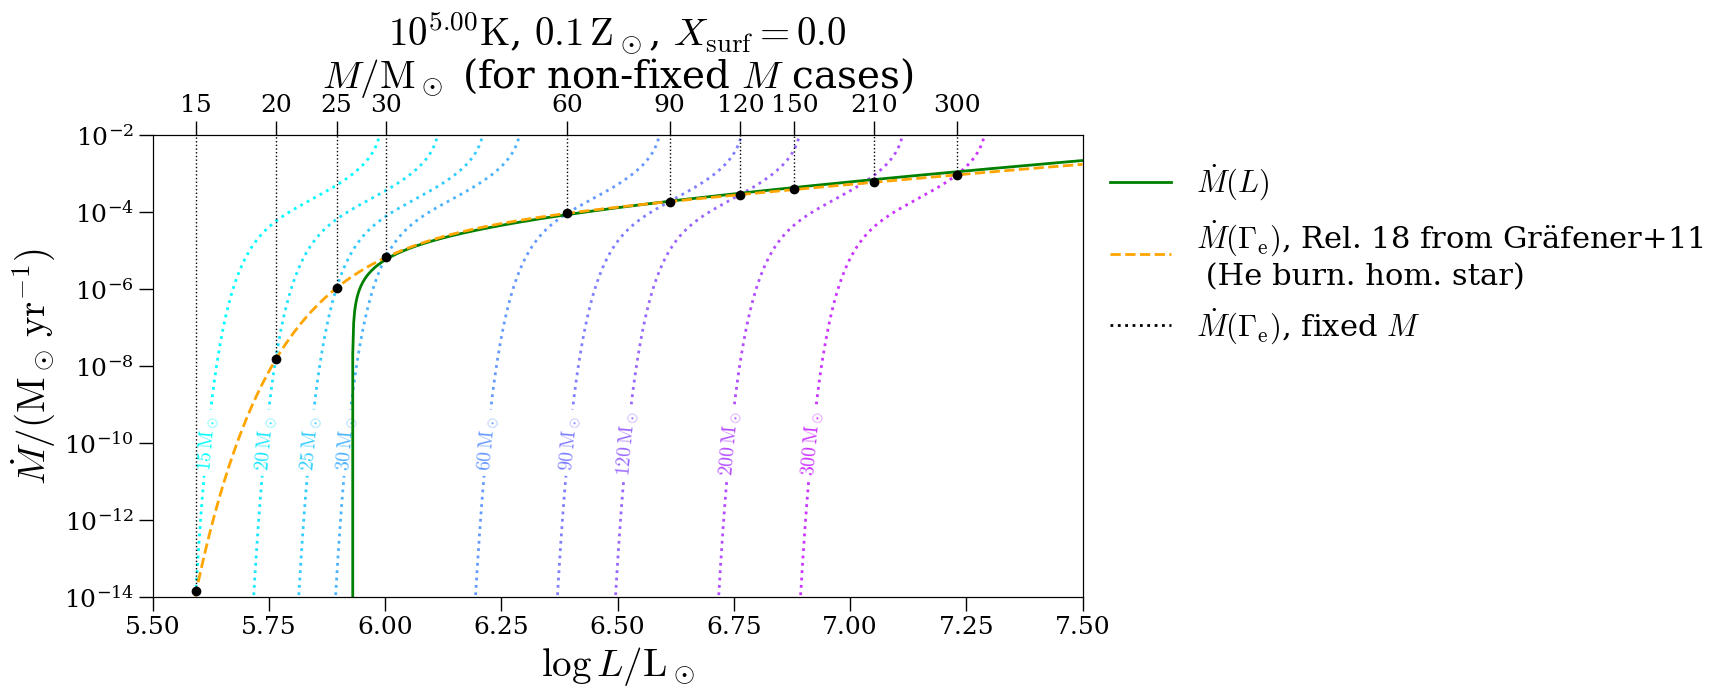

In [35]:
# Setup

figsize = (12, 6)
save = True
fname = 'sander_w_l_ge_mismatch'

plot_x_len = 1000

plot_log_l = np.linspace(5.5, 7.5, plot_x_len)
plot_teff = np.tile([10.**5], plot_x_len)
plot_m = np.tile([50], plot_x_len)
plot_m_h = np.array([grafener_l_to_m_h_burning(10.**log_l, x) for log_l, x in zip(plot_log_l, plot_x)])
plot_m_he = np.array([grafener_l_to_m_he_burning(10.**log_l) for log_l in plot_log_l])
plot_z = np.tile([Z_SUN/10], plot_x_len)
plot_x = np.tile([0], plot_x_len)

plot_g_s23 = np.array([
    sander2023_ge_w(10.**log_l, m, t, z, x) for log_l, m, t, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
])
plot_g_mh_s23 = np.array([
    sander2023_ge_w(10.**log_l, m, t, z, x) for log_l, m, t, z, x in zip(plot_log_l, plot_m_h, plot_teff, plot_z, plot_x)
])
plot_g_mhe_s23 = np.array([
    sander2023_ge_w(10.**log_l, m, t, z, x) for log_l, m, t, z, x in zip(plot_log_l, plot_m_he, plot_teff, plot_z, plot_x)
])
plot_l_s23 = np.array([
    sander2023_l_w(10.**log_l, t, z) for log_l, t, z in zip(plot_log_l, plot_teff, plot_z)
])

#Plot

aspect_ratio = figsize[1]/figsize[0]
fig, ax = plt.subplots(figsize=figsize)

#x = edd_gamma(10.**plot_log_l, plot_m, plot_x)
x = plot_log_l
invert_xaxis = False

#ax.plot(x, plot_g_s23, color=s23_c, ls='-', label='$\dot{M}(\Gamma_\mathrm{e})$, fixed M')
ax.plot(x, plot_l_s23, color='g', ls='-', label='$\dot{M}(L)$', zorder=3)
ax.plot(x, plot_g_mhe_s23, color='orange', ls='--', label='$\dot{M}(\Gamma_\mathrm{e})$, Rel. 18 from Gräfener+11 \n (He burn. hom. star)', zorder=3)

ax.set_xlim(min(x), max(x))
if invert_xaxis:
    ax.invert_xaxis()
ax.set_yscale('log')
ax.set_ylim(10.**-12, 10**-1)
scale_ratio = (-1 + 12) / (ax.get_xlim()[1] - ax.get_xlim()[0])

plot_ms = np.array([15, 20, 25, 30, 60, 90, 120, 200, 300])
for i, m in enumerate(plot_ms):
    #c = cm.cool((m-30)/270)
    c = cm.cool(i/(1+len(plot_ms)))
    plot_m = np.tile([m], plot_x_len)
    plot_g_s23 = np.array([
        sander2023_ge_w(10.**log_l, m, t, z, x) for log_l, m, t, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
    ])
    ax.plot(x, plot_g_s23, color=c, ls=':')#, label=f'$\dot{{M}}(\Gamma_\mathrm{{e}}), M={m:.0f}\,\mathrm{{M}}_\odot$')
    
    text_y = 10.**-10
    text_i = np.where(plot_g_s23 > text_y)[0][0]
    text_x = x[text_i]
    text_inclination = (np.log10(plot_g_s23[text_i+5]) - np.log10(plot_g_s23[text_i-5])) / (x[text_i+5] - x[text_i-5]) / scale_ratio * aspect_ratio
    bbox = dict(boxstyle='square', edgecolor='none', facecolor='white', alpha=1)
    ax.text(text_x, text_y, f'${m:.0f}\\,\\mathrm{{M}}_\\odot$', color=c, fontsize=14, ha='center', va='center', rotation=np.degrees(np.arctan(text_inclination)), bbox=bbox, zorder=2)

m_ax = ax.twiny()
logl_xticks = ax.get_xticks()
#m_xticks = [grafener_l_to_m_he_burning(10.**log_l) for log_l in logl_xticks]
m_ticklabels = [15, 20, 25, 30, 60, 90, 120, 150, 210, 300]
m_ticks = [np.log10(grafener_m_to_l_he_burning(m)) for m in m_ticklabels]
m_ax.set_xlim(ax.get_xlim())
m_ax.set_xticks(m_ticks)
m_ax.set_xticklabels(m_ticklabels)
m_ax.set_xlabel('$M/\mathrm{M}_\odot$ (for non-fixed $M$ cases)')

for m, logl in zip(m_ticklabels, m_ticks):
    mdot = sander2023_ge_w(10.**logl, m, 1e5, Z_SUN/10, 0)
    ax.vlines(logl, mdot, 1e-2, color='k', ls=':', lw=1, zorder=3)
    ax.scatter(logl, mdot, color='k', zorder=3)

handles, labels = ax.get_legend_handles_labels()
handles.append(
    ax.plot([], [], 'k:', label=f'$\dot{{M}}(\Gamma_\mathrm{{e}})$, fixed $M$')[0]
)
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$\dot{M}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
ax.set_title(', '.join((
    f'$10^{{{np.log10(np.unique(plot_teff)[0]):.2f}}}\mathrm{{K}}$',
    f'${np.unique(plot_z)[0]/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$',
    f'$X_\mathrm{{surf}}={np.unique(plot_x)[0]:.1f}$'
)))

ax.set_ylim(1e-14, 1e-2)

if save:
    savefig(fig, fname)

Above we confirm that, for as long the G11 MLR is assumed, the $\Gamma_\mathrm{e}$-prescription (dashed orange line) does reproduce the $L$-prescription ($L$); it, however, also gives us the freedom to, for a fixed mass, assume luminosities that do not follow the MLR. In this case we get the relations show as dotted lines for different masses (colors from cyan to magenta), and we see that, with a free luminosity, any mass loss rate can be found for any mass within the original range of the $L$-prescription and beyond. This allows for a strong potential for mismatch, which we do encounter when running MESA models with the two different prescriptions. 

Because, for a fixed mass, HeMS stars are more luminous than pre-HeMS stars (yielding also greater $\Gamma_\mathrm{e}$), using the $L$-prescription yields greater mass loss rates in the MS, when homogeneous stars already start transitioning to WR winds. This extra mass loss also makes it more likely for a runaway stripping where mass is lost, $Y_\mathrm{surf}$ increases, leading to stronger winds. Thus using the $\Gamma_\mathrm{e}$-prescription also results in more massive stars at He-iginition, which we have found to lead MESA models to crash. Thus, we might opt to implement the $L$-prescription, if for no other reason than stability.

#### As a power-law over masses

For the purpose of describing the production of a final mass pile-up from thick winds that scale strongly with mass, it is convenient to verify how this prescription behaves as approximately a power-law over masses. For a demonstrative estimate, it will be enough to consider the winds of HeMS stars, so that we can adopt the Gräfener et al. (2011) MLR.

**Sander et al. (2023)**

In [75]:
pl_t = 10.**4.75
pl_z = 10.**np.arange(-1, 1, 0.25) * Z_SUN
pl_l = np.logspace(6.7, 8, 10000)
pl_m = np.array([grafener_l_to_m_he_burning(l) for l in pl_l])


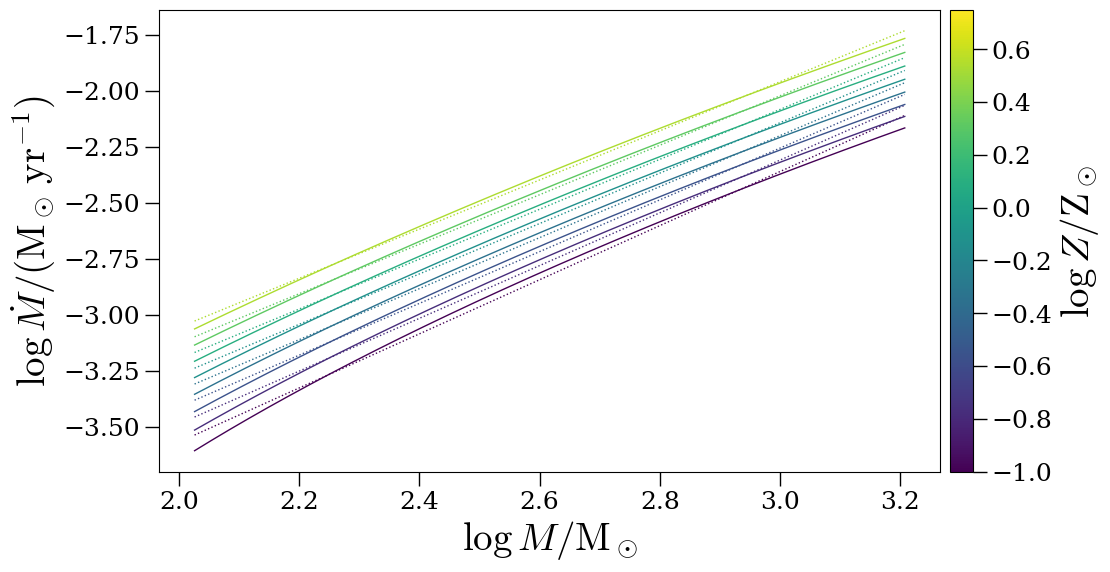

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.viridis

z_fit = np.zeros((len(pl_z), 3))

x = np.log10(pl_m)
for i, z in enumerate(pl_z):
    c = cmap((np.log10(z/Z_SUN)+1)/2)
    y = np.log10(sander2023_l_w(pl_l, pl_t, z))
    ax.plot(x, y, '-', c=c, lw=1)

    reg_x = x[~np.isinf(y)] - np.log10(30)
    reg_y = y[~np.isinf(y)]
    slope, norm, *_ = linregress(np.copy(reg_x), np.copy(reg_y))
    ax.plot(x, norm+slope*(x-np.log10(30)), ':', c=c, lw=1)

    z_fit[i] = (np.log10(z/Z_SUN), norm, slope)

ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')
ax.set_xlabel('$\\log M/\\mathrm{M}_\\odot$')

sm = cm.ScalarMappable(Normalize(vmin=-1, vmax=0.75), cmap=cmap)
cb = fig.colorbar(sm, ax=ax, pad=0.01)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
#ax.set_xlim(0, 3.5)

Text(0.5, 1.0, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})=0.32\\log Z/\\mathrm{Z}_\\odot -3.86$')

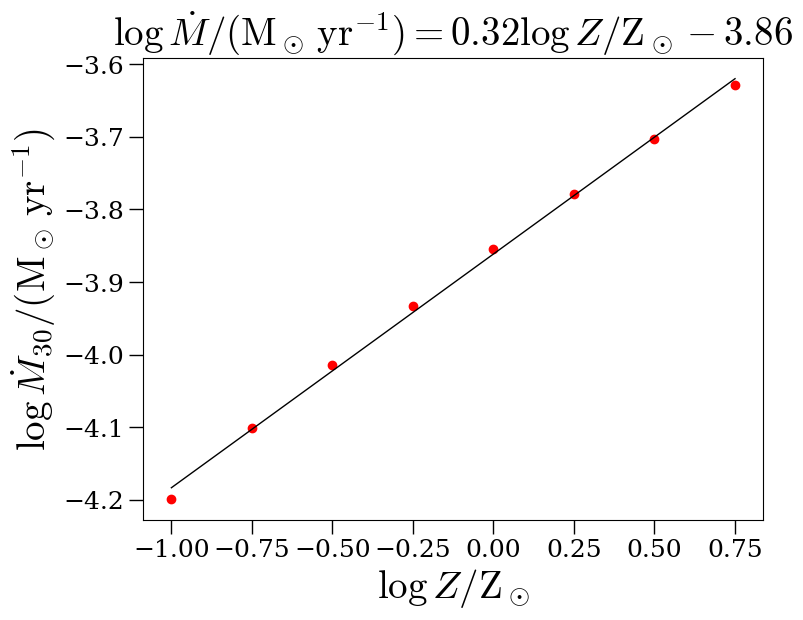

In [78]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(z_fit[:, 0], z_fit[:, 1], c='r')

slope, norm, *_ = linregress(z_fit[:, 0], z_fit[:, 1])
ax.plot(z_fit[:, 0], norm+slope*z_fit[:, 0], '-', c='k', lw=1)
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\log \\dot{M}_{30}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

ax.set_title(f'$\\log\\dot{{M}}/(\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}})={slope:.2f}\\log Z/\\mathrm{{Z}}_\\odot {norm:.2f}$')

In [80]:
(-3.6+4.2)/(0.75+1)

0.3428571428571429

Text(0.5, 1.0, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})=-0.06\\log Z/\\mathrm{Z}_\\odot 1.13$')

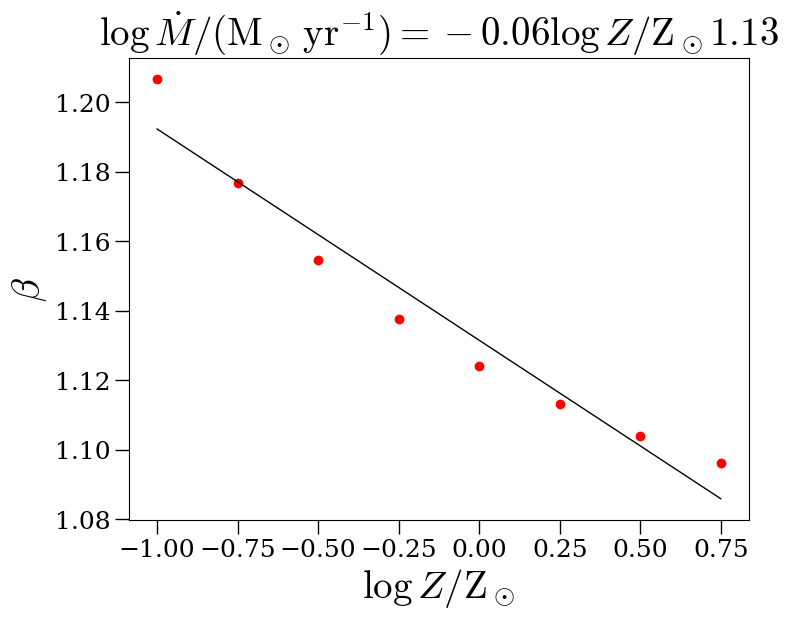

In [79]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(z_fit[:, 0], z_fit[:, 2], c='r')

slope, norm, *_ = linregress(z_fit[:, 0], z_fit[:, 2])
ax.plot(z_fit[:, 0], norm+slope*z_fit[:, 0], '-', c='k', lw=1)
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\beta$')

ax.set_title(f'$\\log\\dot{{M}}/(\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}})={slope:.2f}\\log Z/\\mathrm{{Z}}_\\odot {norm:.2f}$')

**Sander et al. (2023) and Vink (2017)**

/tmp/ipykernel_81156/450554214.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(sander2023_l_w(pl_l, pl_t, z))


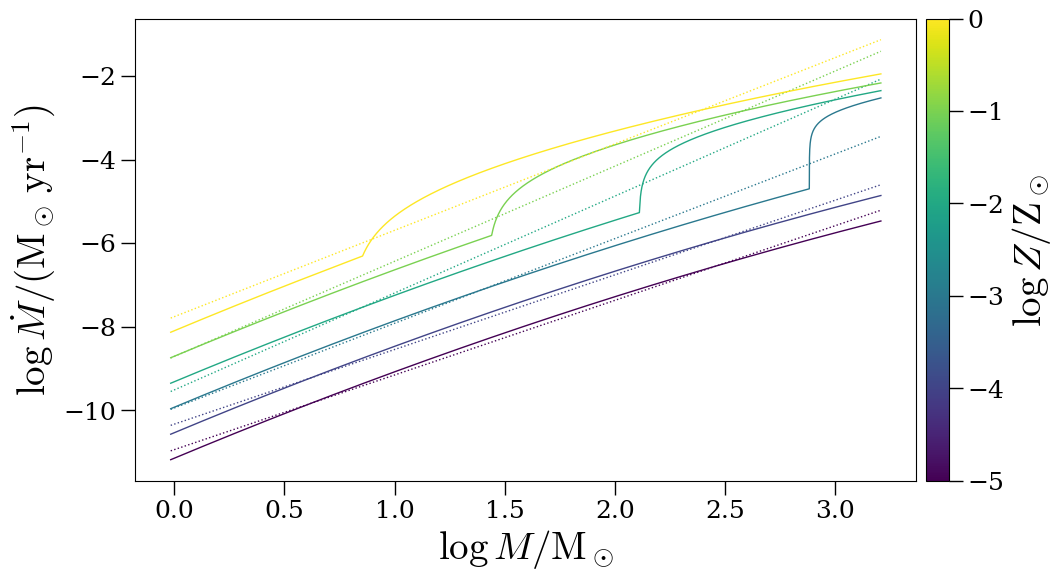

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.viridis

z_fit = np.zeros((len(pl_z), 3))

x = np.log10(pl_m)
for i, z in enumerate(pl_z):
    c = cmap((np.log10(z/Z_SUN)+5)/5)
    y = np.log10(sander2023_l_w(pl_l, pl_t, z))
    y2 = np.log10(vink2017_w(pl_l, z))
    y = np.max([y, y2], axis=0)
    #ax.plot(x, y, '--', c=c, lw=0.5)
    #ax.plot(x, y2, '--', c=c, lw=0.5)
    ax.plot(x, y, '-', c=c, lw=1)
    
    
    reg_x = x[~np.isinf(y)] - np.log10(30)
    reg_y = y[~np.isinf(y)]
    slope, norm, *_ = linregress(np.copy(reg_x), np.copy(reg_y))
    ax.plot(x, norm+slope*(x-np.log10(30)), ':', c=c, lw=1)

    z_fit[i] = (np.log10(z/Z_SUN), norm, slope)

ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')
ax.set_xlabel('$\\log M/\\mathrm{M}_\\odot$')

sm = cm.ScalarMappable(Normalize(vmin=-5, vmax=0), cmap=cmap)
cb = fig.colorbar(sm, ax=ax, pad=0.01)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
#ax.set_xlim(0, 3.5)

Text(0.5, 1.0, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})=0.74\\log Z/\\mathrm{Z}_\\odot -4.67$')

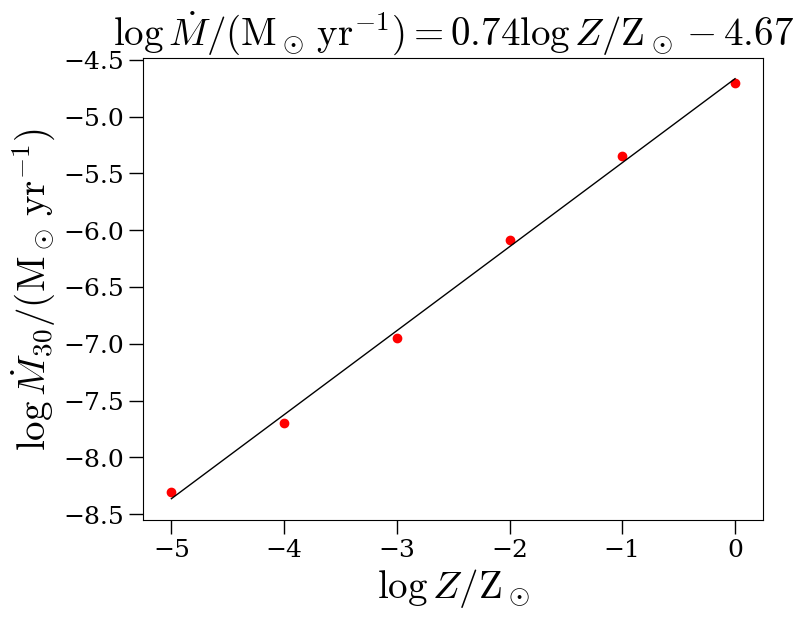

In [52]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(z_fit[:, 0], z_fit[:, 1], c='r')

slope, norm, *_ = linregress(z_fit[:, 0], z_fit[:, 1])
ax.plot(z_fit[:, 0], norm+slope*z_fit[:, 0], '-', c='k', lw=1)
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\log \\dot{M}_{30}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

ax.set_title(f'$\\log\\dot{{M}}/(\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}})={slope:.2f}\\log Z/\\mathrm{{Z}}_\\odot {norm:.2f}$')

Text(0.5, 1.0, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})=0.09\\log Z/\\mathrm{Z}_\\odot 2.27$')

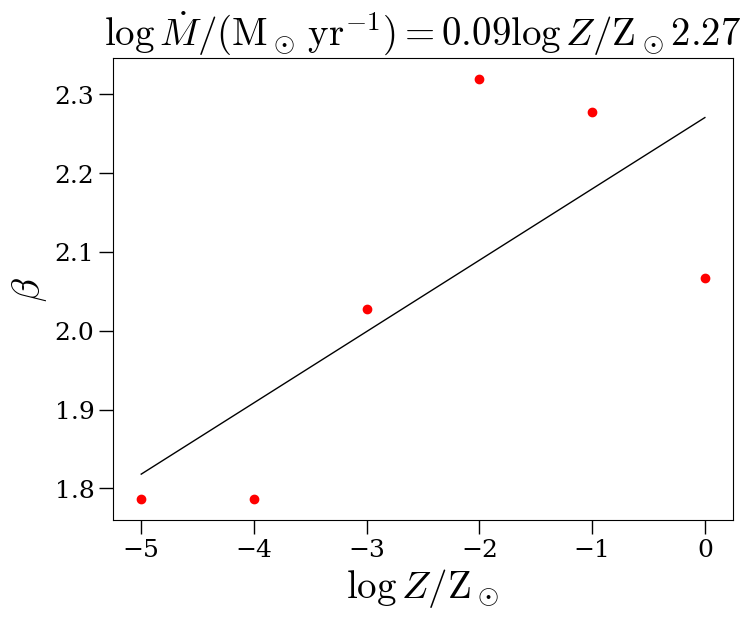

In [56]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(z_fit[:, 0], z_fit[:, 2], c='r')

slope, norm, *_ = linregress(z_fit[:, 0], z_fit[:, 2])
ax.plot(z_fit[:, 0], norm+slope*z_fit[:, 0], '-', c='k', lw=1)
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\beta$')

ax.set_title(f'$\\log\\dot{{M}}/(\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}})={slope:.2f}\\log Z/\\mathrm{{Z}}_\\odot {norm:.2f}$')

Text(0.5, 1.0, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})=0.74\\log Z/\\mathrm{Z}_\\odot -4.67$')

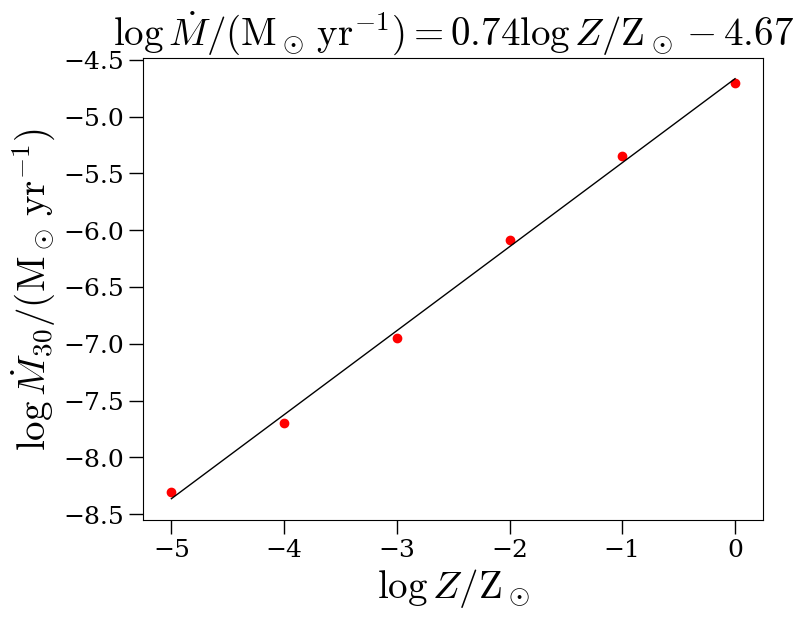

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(z_norm[:, 0], z_norm[:, 1], c='r')

slope, norm, *_ = linregress(z_norm[:, 0], z_norm[:, 1])
ax.plot(z_norm[:, 0], norm+slope*z_norm[:, 0], '-', c='k', lw=1)
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\log \\dot{M}_{30}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

ax.set_title(f'$\\log\\dot{{M}}/(\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}})={slope:.2f}\\log Z/\\mathrm{{Z}}_\\odot {norm:.2f}$')

#### Gräfener & Hamann (2008)

While the Sander & Vink (2020) and Sander et al. (2023) recipes model thick He-rich winds launched by the hot Fe bump ($T_\mathrm{eff}>100\,\mathrm{kK}$), Gräfener & Hamann (2008) modeled winds launched by the cool Fe bump ($30<T_\mathrm{eff}/\mathrm{kK}<70$).

In [42]:
def grafener2008_w(l, m, t_eff, z, x):
    beta = 1.727 + 0.250 * np.log10(z/Z_SUN)
    g_0 = 0.326 - 0.301 * np.log10(z/Z_SUN) - 0.045 * np.log10(z/Z_SUN)**2
    g_e = edd_gamma(l, m, x)
    if g_e > g_0:
        log_mdot = (
            10.046
            + beta * np.log10(g_e - g_0)
            - 3.5 * np.log10(t_eff)
            + 0.42 * np.log10(l)
            - 0.45 * x
        )
        w = 10.**log_mdot
    else:
        w = 0
    return w

### An incomplete picture of He-rich winds

In [43]:
def get_wr_wind_plot_data(m, log_l, z, x, plot_xlen=1000, min_teff=4.5, max_teff=5.4):
    plot_teff = np.logspace(min_teff, max_teff, plot_xlen)
    plot_log_l = np.tile([log_l], plot_xlen)
    plot_m = np.tile([m], plot_xlen)
    plot_z = np.tile([z], plot_xlen)
    plot_x = np.tile([x], plot_xlen)

    plot_s23 = np.array([
        sander2023_l_w(10.**log_l, t, z) for log_l, t, z in zip(plot_log_l, plot_teff, plot_z)
    ])
    plot_g08 = np.array([
        grafener2008_w(10.**log_l, m, t, z, x) for log_l, m, t, z, x in zip(plot_log_l, plot_m, plot_teff, plot_z, plot_x)
    ])
    plot_v17 = np.array([
        vink2017_w(10.**log_l, z) for log_l, z in zip(plot_log_l, plot_z)
    ])

    plot_s23 = np.log10(plot_s23)
    plot_g08 = np.log10(plot_g08)
    plot_v17 = np.log10(plot_v17)
    
    return plot_teff, plot_s23, plot_g08, plot_v17

In [44]:
def get_annotate_kwargs(c):    
    annotate_kwargs = dict(
        xycoords='data',
        textcoords='offset points',
        fontsize=8,
        color=c,
        arrowprops=dict(arrowstyle='fancy', fc=c, ec='none', shrinkB=5)
        )
    return annotate_kwargs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


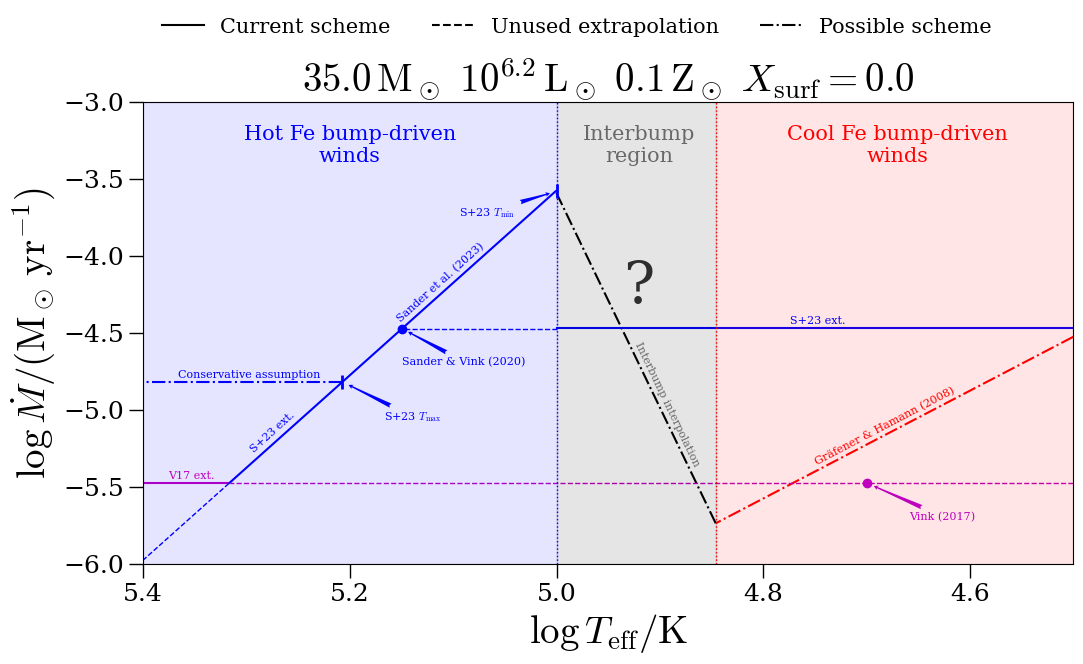

In [45]:
## Set star params and generate data

save = True
fname = 'wr_wind_recipes'
figsize = (12, 6)

m = 35
log_l = 6.2
z = Z_SUN/10
x = 0.
plot_xlen = 1000
min_teff = 4.5
max_teff = 5.4
min_logmdot = -6
max_logmdot = -3
plot_teff, plot_s23, plot_g08, plot_v17 = get_wr_wind_plot_data(m, log_l, z, x, plot_xlen=plot_xlen, min_teff=min_teff, max_teff=max_teff)

## Plot
aspect_ratio = figsize[1]/figsize[0]
fig, ax = plt.subplots(figsize=figsize)

plot_logt = np.log10(plot_teff)
minx = min_teff
maxx = max_teff
miny = min_logmdot
maxy = max_logmdot
scale_ratio = (maxy-miny) / (maxx-minx)

v17_model_i = np.where(plot_logt >= np.log10(5e4))[0][0]
hot_bump_upper_lim_i = np.where(plot_logt >= 5)[0][0]
cool_bump_lower_lim_i = np.where(plot_logt >= np.log10(7e4))[0][0]
s20_model_i = np.where(plot_logt >= np.log10(1.41e5))[0][0]
s23_upper_lim_i = np.where(plot_logt >= np.log10(1.61e5))[0][0]
s23_v17_cross_i = np.where(plot_s23-plot_v17 <= 0)[0][0]

# Vink (2017)

ax.plot(plot_logt[:s23_v17_cross_i], plot_v17[:s23_v17_cross_i], 'm--', lw=1, zorder=2)
ax.plot(plot_logt[s23_v17_cross_i:], plot_v17[s23_v17_cross_i:], 'm-', lw=1.5, zorder=2)   

ax.scatter(plot_logt[v17_model_i], plot_v17[v17_model_i], color='m', zorder=3)
ax.annotate(
    'Vink (2017)',
    xy=(plot_logt[v17_model_i], plot_v17[v17_model_i]),
    xytext=(+30, -20),
    ha='left',
    va='top',
    **get_annotate_kwargs('m')
    )
ax.text(
    plot_logt[s23_v17_cross_i+40],
    plot_v17[s23_v17_cross_i+40] + 0.05,
    'V17 ext.',
    ha='center',
    va='center',
    fontsize=8,
    color='m'
)

# Sander & Vink (2020)

ax.scatter(plot_logt[s20_model_i], plot_s23[s20_model_i], color='b', marker='o', zorder=3)
ax.annotate(
    'Sander & Vink (2020)',
    xy=(plot_logt[s20_model_i], plot_s23[s20_model_i]),
    xytext=(0, -20),
    ha='left',
    va='top',
    **get_annotate_kwargs('b')
    )

# Sander et al. (2023)
ax.plot(plot_logt[s23_v17_cross_i:], plot_s23[s23_v17_cross_i:], 'b--', lw=1, zorder=2)
ax.plot(plot_logt[hot_bump_upper_lim_i+1:s23_v17_cross_i], plot_s23[hot_bump_upper_lim_i+1:s23_v17_cross_i], 'b-', lw=1.5, zorder=2)
ax.plot(plot_logt[:hot_bump_upper_lim_i], plot_s23[:hot_bump_upper_lim_i], 'b-', lw=1.5, zorder=2)

ax.hlines(plot_s23[s20_model_i], plot_logt[hot_bump_upper_lim_i], plot_logt[s20_model_i], color='b', ls='--', lw=1, zorder=2)
ax.hlines(plot_s23[s23_upper_lim_i], plot_logt[s23_upper_lim_i], 5.4, color='b', ls='-.', lw=1.5, zorder=2)
ax.text(
    plot_logt[s23_upper_lim_i+100],
    plot_s23[s23_upper_lim_i] + 0.05,
    "Conservative assumption",
    ha='center',
    va='center',
    fontsize=8,
    color='b'
)

s23_inclination = - (plot_s23[hot_bump_upper_lim_i+1] - plot_s23[s23_upper_lim_i]) / (plot_logt[hot_bump_upper_lim_i+1] - plot_logt[s23_upper_lim_i]) / scale_ratio * aspect_ratio
ax.text(
    (plot_logt[hot_bump_upper_lim_i] + plot_logt[s23_upper_lim_i]) / 2 + 0.03/scale_ratio,
    (plot_s23[hot_bump_upper_lim_i+1] + plot_s23[s23_upper_lim_i]) / 2 + 0.03,
    'Sander et al. (2023)',
    ha='center',
    va='center',
    rotation=np.degrees(np.arctan(s23_inclination)),
    fontsize=8,
    color='b'
)

ax.text(
    plot_logt[s23_upper_lim_i+65] + 0.03/scale_ratio,
    plot_s23[s23_upper_lim_i+65] + 0.03,
    'S+23 ext.',
    ha='center',
    va='center',
    rotation=np.degrees(np.arctan(s23_inclination)),
    fontsize=8,
    color='b'
)

ax.text(
    plot_logt[cool_bump_lower_lim_i-110],
    plot_s23[cool_bump_lower_lim_i-110] + 0.05,
    'S+23 ext.',
    ha='center',
    va='center',
    fontsize=8,
    color='b'
)

ax.scatter(plot_logt[hot_bump_upper_lim_i], plot_s23[hot_bump_upper_lim_i+1], color='b', marker='|', s=100, zorder=3)
ax.annotate(
    'S+23 $T_\mathrm{min}$',
    xy=(plot_logt[hot_bump_upper_lim_i], plot_s23[hot_bump_upper_lim_i+1]),
    xytext=(-30, -20),
    ha='right',
    va='bottom',
    **get_annotate_kwargs('b')
    )

ax.scatter(plot_logt[s23_upper_lim_i], plot_s23[s23_upper_lim_i], color='b', marker='|', s=100, zorder=3)
ax.annotate(
    'S+23 $T_\mathrm{max}$',
    xy=(plot_logt[s23_upper_lim_i], plot_s23[s23_upper_lim_i]),
    xytext=(+30, -20),
    ha='left',
    va='top',
    **get_annotate_kwargs('b')
    )


# Gräfener & Hamann (2008)

if np.unique(plot_g08)[0] == -np.inf:
    ax.text(
        4.67, 
        -5,
        '$\Gamma_\mathrm{e}<\Gamma_0^\mathrm{GH08}$',
        ha='center',
        va='top',
        color='r',
        fontsize=15,
        zorder=3
    )
else:
    ax.plot(plot_logt[:cool_bump_lower_lim_i], plot_g08[:cool_bump_lower_lim_i], 'r-.', lw=1.5, zorder=1)
    gh08_inclination = -(
        (plot_g08[cool_bump_lower_lim_i] - plot_g08[0]) 
        / (plot_logt[cool_bump_lower_lim_i] - plot_logt[0]) 
        / scale_ratio 
        * aspect_ratio
    )
    ax.text(
        (plot_logt[cool_bump_lower_lim_i] + plot_logt[0]) / 2 + 0.03/scale_ratio,
        (plot_g08[cool_bump_lower_lim_i] + plot_g08[0]) / 2 + 0.03,
        'Gräfener & Hamann (2008)',
        ha='center',
        va='center',
        rotation=np.degrees(np.arctan(gh08_inclination)),
        fontsize=8,
        color='r'
    )
    
# Interbump interpolation

ax.plot(
    [plot_logt[cool_bump_lower_lim_i], plot_logt[hot_bump_upper_lim_i+1]],
    [plot_g08[cool_bump_lower_lim_i], plot_s23[hot_bump_upper_lim_i+1]],
    'k-.',
    lw=1.5,
    zorder=1
)
ip_inclination = -(
    (plot_s23[hot_bump_upper_lim_i+1] - plot_g08[cool_bump_lower_lim_i]) 
    / (plot_logt[hot_bump_upper_lim_i+1] - plot_logt[cool_bump_lower_lim_i]) 
    / scale_ratio 
    * aspect_ratio
)
ax.text(
    (plot_logt[hot_bump_upper_lim_i+1] + plot_logt[cool_bump_lower_lim_i]) / 2 - 0.1/scale_ratio,
    (plot_s23[hot_bump_upper_lim_i+1] + plot_g08[cool_bump_lower_lim_i]) / 2 - 0.3,
    'Interbump interpolation',
    ha='center',
    va='center',
    rotation=np.degrees(np.arctan(ip_inclination)),
    fontsize=8,
    color='dimgray'
)

# Regions

ax.axvspan(min_teff, plot_logt[cool_bump_lower_lim_i], color='r', alpha=0.1, zorder=2)
ax.axvspan(plot_logt[hot_bump_upper_lim_i], plot_logt[cool_bump_lower_lim_i], color='k', alpha=0.1, zorder=2)
ax.axvspan(plot_logt[hot_bump_upper_lim_i], max_teff, color='b', alpha=0.1, zorder=2)
ax.vlines(plot_logt[hot_bump_upper_lim_i], min_logmdot, max_logmdot, color='b', linestyle=':', lw=1, zorder=3)
ax.vlines(plot_logt[cool_bump_lower_lim_i], min_logmdot, max_logmdot, color='r', linestyle=':', lw=1, zorder=3)

# Our model plot
model_plot_kws = {
    'color': 'black',
    'lw': 0.5,
    'alpha': 1,
    'zorder': 0
}
#ax.scatter(plot_logt[s23_v17_cross_i], plot_s23[s23_v17_cross_i], zorder=3)
#ax.plot(plot_logt[s23_v17_cross_i:], plot_v17[s23_v17_cross_i:]-0.05, **model_plot_kws)
#ax.plot(plot_logt[:s23_v17_cross_i], plot_s23[:s23_v17_cross_i]-0.05, **model_plot_kws)

ax.text(
    5.2, 
    0.95,
    'Hot Fe bump-driven\nwinds',
    ha='center',
    va='top',
    color='b',
    fontsize=15,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
    )

ax.text(
    4.67, 
    0.95,
    'Cool Fe bump-driven\nwinds',
    ha='center',
    va='top',
    color='r',
    fontsize=15,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
    )

ax.text(
    4.92,
    0.95,
    'Interbump\nregion',
    ha='center',
    va='top',
    color='dimgray',
    fontsize=15,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
)

ax.text(
    4.92,
    0.6,
    '?',
    ha='center',
    va='center',
    color='black',
    alpha=0.8,
    fontsize=42,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
)

ax.set_xlim(maxx, minx)
ax.set_ylim(miny, maxy)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', lw=1.5, label='Current scheme'))
handles.append(Line2D([], [], color='k', ls='--', lw=1.5, label='Unused extrapolation'))
handles.append(Line2D([], [], color='k', ls='-.', lw=1.5, label='Possible scheme'))
ax.legend(handles=handles, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.1), ncol=3, fontsize=15)

ax.set_xlabel('$\\log T_\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log \\dot{M}/(\\mathrm{M}_\\odot\\,\mathrm{yr}^{-1})$')
ax.set_title((f'${m:.1f}\\,\\mathrm{{M}}_\odot$ ' 
              f'$10^{{{log_l:.1f}}}\\,\\mathrm{{L}}_\\odot$'
              f' ${z/Z_SUN:.1f}\,\mathrm{{Z}}_\\odot$'
              f' $X_\\mathrm{{surf}}={x:.1f}$'
              ),)

if save:
    savefig(fig, fname)

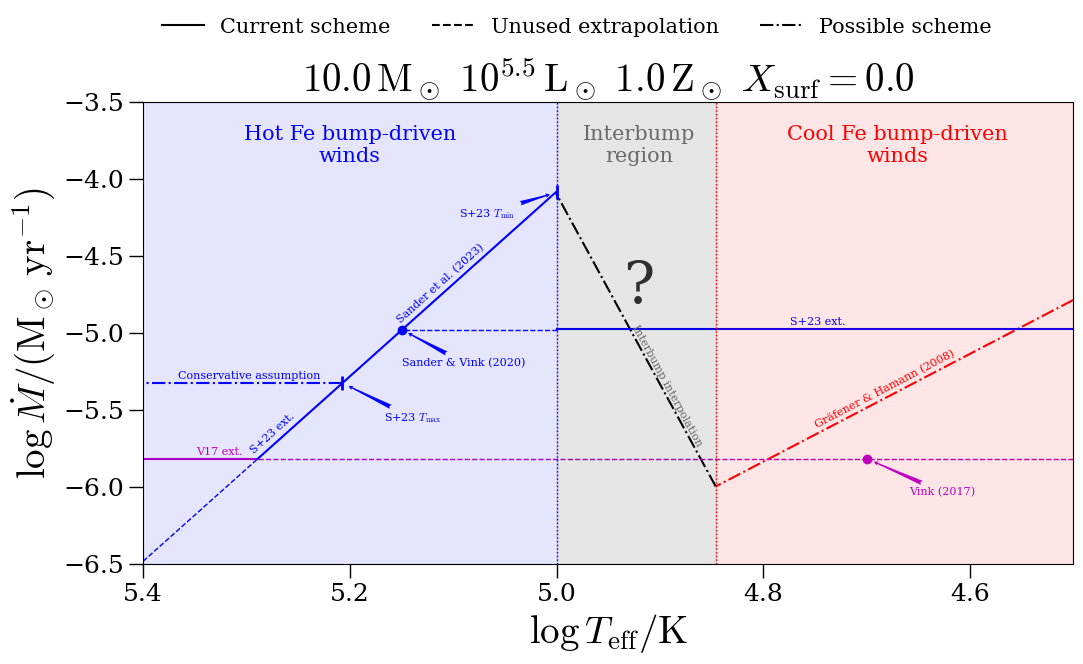

In [46]:
## Set star params and generate data

save = False
fname = 'wr_wind_recipes'
figsize = (12, 6)

m = 10
log_l = 5.5
z = Z_SUN
x = 0
plot_xlen = 1000
min_teff = 4.5
max_teff = 5.4
min_logmdot = -6.5
max_logmdot = -3.5
plot_teff, plot_s23, plot_g08, plot_v17 = get_wr_wind_plot_data(m, log_l, z, x, plot_xlen=plot_xlen, min_teff=min_teff, max_teff=max_teff)

## Plot
aspect_ratio = figsize[1]/figsize[0]
fig, ax = plt.subplots(figsize=figsize)

plot_logt = np.log10(plot_teff)
minx = min_teff
maxx = max_teff
miny = min_logmdot
maxy = max_logmdot
scale_ratio = (maxy-miny) / (maxx-minx)

v17_model_i = np.where(plot_logt >= np.log10(5e4))[0][0]
hot_bump_upper_lim_i = np.where(plot_logt >= 5)[0][0]
cool_bump_lower_lim_i = np.where(plot_logt >= np.log10(7e4))[0][0]
s20_model_i = np.where(plot_logt >= np.log10(1.41e5))[0][0]
s23_upper_lim_i = np.where(plot_logt >= np.log10(1.61e5))[0][0]
s23_v17_cross_i = np.where(plot_s23-plot_v17 <= 0)[0][0]

# Vink (2017)

ax.plot(plot_logt[:s23_v17_cross_i], plot_v17[:s23_v17_cross_i], 'm--', lw=1, zorder=2)
ax.plot(plot_logt[s23_v17_cross_i:], plot_v17[s23_v17_cross_i:], 'm-', lw=1.5, zorder=2)   

ax.scatter(plot_logt[v17_model_i], plot_v17[v17_model_i], color='m', zorder=3)
ax.annotate(
    'Vink (2017)',
    xy=(plot_logt[v17_model_i], plot_v17[v17_model_i]),
    xytext=(+30, -20),
    ha='left',
    va='top',
    **get_annotate_kwargs('m')
    )
ax.text(
    plot_logt[s23_v17_cross_i+40],
    plot_v17[s23_v17_cross_i+40] + 0.05,
    'V17 ext.',
    ha='center',
    va='center',
    fontsize=8,
    color='m'
)

# Sander & Vink (2020)

ax.scatter(plot_logt[s20_model_i], plot_s23[s20_model_i], color='b', marker='o', zorder=3)
ax.annotate(
    'Sander & Vink (2020)',
    xy=(plot_logt[s20_model_i], plot_s23[s20_model_i]),
    xytext=(0, -20),
    ha='left',
    va='top',
    **get_annotate_kwargs('b')
    )

# Sander et al. (2023)
ax.plot(plot_logt[s23_v17_cross_i:], plot_s23[s23_v17_cross_i:], 'b--', lw=1, zorder=2)
ax.plot(plot_logt[hot_bump_upper_lim_i+1:s23_v17_cross_i], plot_s23[hot_bump_upper_lim_i+1:s23_v17_cross_i], 'b-', lw=1.5, zorder=2)
ax.plot(plot_logt[:hot_bump_upper_lim_i], plot_s23[:hot_bump_upper_lim_i], 'b-', lw=1.5, zorder=2)

ax.hlines(plot_s23[s20_model_i], plot_logt[hot_bump_upper_lim_i], plot_logt[s20_model_i], color='b', ls='--', lw=1, zorder=2)
ax.hlines(plot_s23[s23_upper_lim_i], plot_logt[s23_upper_lim_i], 5.4, color='b', ls='-.', lw=1.5, zorder=2)
ax.text(
    plot_logt[s23_upper_lim_i+100],
    plot_s23[s23_upper_lim_i] + 0.05,
    "Conservative assumption",
    ha='center',
    va='center',
    fontsize=8,
    color='b'
)

s23_inclination = - (plot_s23[hot_bump_upper_lim_i+1] - plot_s23[s23_upper_lim_i]) / (plot_logt[hot_bump_upper_lim_i+1] - plot_logt[s23_upper_lim_i]) / scale_ratio * aspect_ratio
ax.text(
    (plot_logt[hot_bump_upper_lim_i] + plot_logt[s23_upper_lim_i]) / 2 + 0.03/scale_ratio,
    (plot_s23[hot_bump_upper_lim_i+1] + plot_s23[s23_upper_lim_i]) / 2 + 0.03,
    'Sander et al. (2023)',
    ha='center',
    va='center',
    rotation=np.degrees(np.arctan(s23_inclination)),
    fontsize=8,
    color='b'
)

ax.text(
    plot_logt[s23_upper_lim_i+65] + 0.03/scale_ratio,
    plot_s23[s23_upper_lim_i+65] + 0.03,
    'S+23 ext.',
    ha='center',
    va='center',
    rotation=np.degrees(np.arctan(s23_inclination)),
    fontsize=8,
    color='b'
)

ax.text(
    plot_logt[cool_bump_lower_lim_i-110],
    plot_s23[cool_bump_lower_lim_i-110] + 0.05,
    'S+23 ext.',
    ha='center',
    va='center',
    fontsize=8,
    color='b'
)

ax.scatter(plot_logt[hot_bump_upper_lim_i], plot_s23[hot_bump_upper_lim_i+1], color='b', marker='|', s=100, zorder=3)
ax.annotate(
    'S+23 $T_\mathrm{min}$',
    xy=(plot_logt[hot_bump_upper_lim_i], plot_s23[hot_bump_upper_lim_i+1]),
    xytext=(-30, -20),
    ha='right',
    va='bottom',
    **get_annotate_kwargs('b')
    )

ax.scatter(plot_logt[s23_upper_lim_i], plot_s23[s23_upper_lim_i], color='b', marker='|', s=100, zorder=3)
ax.annotate(
    'S+23 $T_\mathrm{max}$',
    xy=(plot_logt[s23_upper_lim_i], plot_s23[s23_upper_lim_i]),
    xytext=(+30, -20),
    ha='left',
    va='top',
    **get_annotate_kwargs('b')
    )


# Gräfener & Hamann (2008)

if np.unique(plot_g08)[0] == -np.inf:
    ax.text(
        4.67, 
        -5,
        '$\Gamma_\mathrm{e}<\Gamma_0^\mathrm{GH08}$',
        ha='center',
        va='top',
        color='r',
        fontsize=15,
        zorder=3
    )
else:
    ax.plot(plot_logt[:cool_bump_lower_lim_i], plot_g08[:cool_bump_lower_lim_i], 'r-.', lw=1.5, zorder=1)
    gh08_inclination = -(
        (plot_g08[cool_bump_lower_lim_i] - plot_g08[0]) 
        / (plot_logt[cool_bump_lower_lim_i] - plot_logt[0]) 
        / scale_ratio 
        * aspect_ratio
    )
    ax.text(
        (plot_logt[cool_bump_lower_lim_i] + plot_logt[0]) / 2 + 0.03/scale_ratio,
        (plot_g08[cool_bump_lower_lim_i] + plot_g08[0]) / 2 + 0.03,
        'Gräfener & Hamann (2008)',
        ha='center',
        va='center',
        rotation=np.degrees(np.arctan(gh08_inclination)),
        fontsize=8,
        color='r'
    )
    
# Interbump interpolation

ax.plot(
    [plot_logt[cool_bump_lower_lim_i], plot_logt[hot_bump_upper_lim_i+1]],
    [plot_g08[cool_bump_lower_lim_i], plot_s23[hot_bump_upper_lim_i+1]],
    'k-.',
    lw=1.5,
    zorder=1
)
ip_inclination = -(
    (plot_s23[hot_bump_upper_lim_i+1] - plot_g08[cool_bump_lower_lim_i]) 
    / (plot_logt[hot_bump_upper_lim_i+1] - plot_logt[cool_bump_lower_lim_i]) 
    / scale_ratio 
    * aspect_ratio
)
ax.text(
    (plot_logt[hot_bump_upper_lim_i+1] + plot_logt[cool_bump_lower_lim_i]) / 2 - 0.1/scale_ratio,
    (plot_s23[hot_bump_upper_lim_i+1] + plot_g08[cool_bump_lower_lim_i]) / 2 - 0.3,
    'Interbump interpolation',
    ha='center',
    va='center',
    rotation=np.degrees(np.arctan(ip_inclination)),
    fontsize=8,
    color='dimgray'
)

# Regions

ax.axvspan(min_teff, plot_logt[cool_bump_lower_lim_i], color='r', alpha=0.1, zorder=2)
ax.axvspan(plot_logt[hot_bump_upper_lim_i], plot_logt[cool_bump_lower_lim_i], color='k', alpha=0.1, zorder=2)
ax.axvspan(plot_logt[hot_bump_upper_lim_i], max_teff, color='b', alpha=0.1, zorder=2)
ax.vlines(plot_logt[hot_bump_upper_lim_i], min_logmdot, max_logmdot, color='b', linestyle=':', lw=1, zorder=3)
ax.vlines(plot_logt[cool_bump_lower_lim_i], min_logmdot, max_logmdot, color='r', linestyle=':', lw=1, zorder=3)

# Our model plot
model_plot_kws = {
    'color': 'black',
    'lw': 0.5,
    'alpha': 1,
    'zorder': 0
}
#ax.scatter(plot_logt[s23_v17_cross_i], plot_s23[s23_v17_cross_i], zorder=3)
#ax.plot(plot_logt[s23_v17_cross_i:], plot_v17[s23_v17_cross_i:]-0.05, **model_plot_kws)
#ax.plot(plot_logt[:s23_v17_cross_i], plot_s23[:s23_v17_cross_i]-0.05, **model_plot_kws)

ax.text(
    5.2, 
    0.95,
    'Hot Fe bump-driven\nwinds',
    ha='center',
    va='top',
    color='b',
    fontsize=15,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
    )

ax.text(
    4.67, 
    0.95,
    'Cool Fe bump-driven\nwinds',
    ha='center',
    va='top',
    color='r',
    fontsize=15,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
    )

ax.text(
    4.92,
    0.95,
    'Interbump\nregion',
    ha='center',
    va='top',
    color='dimgray',
    fontsize=15,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
)

ax.text(
    4.92,
    0.6,
    '?',
    ha='center',
    va='center',
    color='black',
    alpha=0.8,
    fontsize=42,
    zorder=3,
    transform=blended_transform_factory(ax.transData, ax.transAxes)
)

ax.set_xlim(maxx, minx)
ax.set_ylim(miny, maxy)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', lw=1.5, label='Current scheme'))
handles.append(Line2D([], [], color='k', ls='--', lw=1.5, label='Unused extrapolation'))
handles.append(Line2D([], [], color='k', ls='-.', lw=1.5, label='Possible scheme'))
ax.legend(handles=handles, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.1), ncol=3, fontsize=15)

ax.set_xlabel('$\\log T_\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log \\dot{M}/(\\mathrm{M}_\\odot\\,\mathrm{yr}^{-1})$')
ax.set_title((f'${m:.1f}\\,\\mathrm{{M}}_\odot$ ' 
              f'$10^{{{log_l:.1f}}}\\,\\mathrm{{L}}_\\odot$'
              f' ${z/Z_SUN:.1f}\,\mathrm{{Z}}_\\odot$'
              f' $X_\\mathrm{{surf}}={x:.1f}$'
              ),)

if save:
    savefig(fig, fname)

Essential to knowing how important each choice in our wind scheme is, is to know how much time a typical CHE star spends in each region.